<a href="https://colab.research.google.com/github/thc1006/FLORA/blob/main/0701_FLORA_client_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# @title Cell 1: Áí∞Â¢ÉË®≠ÂÆöËàáÂáΩÂºèÂ∫´ÂåØÂÖ•Ôºà‰øÆÊ≠£ÁâàÔºâ
!pip install --upgrade opacus -q

import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np, pandas as pd, random, copy, json, os, time, warnings, math, re, contextlib
from collections import deque
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt, seaborn as sns
from dataclasses import dataclass, asdict
from sklearn.cluster import KMeans
from opacus import PrivacyEngine
from opacus.validators import ModuleValidator
from opacus.data_loader import DPDataLoader

# --- Áí∞Â¢ÉË®≠ÂÆö ---
try: torch._dynamo.disable()
except Exception: pass
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.filterwarnings("ignore", message=".*overflow encountered.*", category=RuntimeWarning)

pd.options.mode.chained_assignment = None

print("‚úÖ Cell 1: Áí∞Â¢ÉËàáÂáΩÂºèÂ∫´Ê∫ñÂÇôÂ∞±Á∑í„ÄÇ")
import opacus
print(f"PyTorch/Opacus ÁâàÊú¨: {torch.__version__} / {opacus.__version__}")
print(f"CUDA ÊòØÂê¶ÂèØÁî®: {torch.cuda.is_available()}")


‚úÖ Cell 1: Áí∞Â¢ÉËàáÂáΩÂºèÂ∫´Ê∫ñÂÇôÂ∞±Á∑í„ÄÇ
PyTorch/Opacus ÁâàÊú¨: 2.6.0+cu124 / 1.5.4
CUDA ÊòØÂê¶ÂèØÁî®: True


In [11]:
# @title Cell 2: üéì ÂØ¶È©óÂèÉÊï∏Ë®≠ÂÆöÔºà7ÂÆ¢Êà∂Á´ØÁâàÔºâ
@dataclass
class TrainingConfig:
    experiment_name: str; output_dir: str
    mode: str = "ClusteredFL"
    random_seed: int = 42
    comm_rounds: int = 35  # Â¢ûÂä†ÈÄö‰ø°Ëº™Êï∏‰ª•ÈÅ©ÊáâÊõ¥Â§öÂÆ¢Êà∂Á´Ø

    # ‰øÆÊ≠£Ôºö7ÂÆ¢Êà∂Á´ØÈÖçÁΩÆÔºåÊØèÂÄãBSÁç®Á´ãÊàêÁÇ∫‰∏ÄÂÄãÂÆ¢Êà∂Á´Ø
    # ÂÆ¢Êà∂Á´Ø0-3‰ΩøÁî®eMBBÂàáÁâáÔºåÂÆ¢Êà∂Á´Ø4-6‰ΩøÁî®URLLCÂàáÁâá
    client_pairs: tuple = ((1, 0), (2, 0), (3, 0), (4, 0), (5, 2), (6, 2), (7, 2))
    num_clients: int = 7
    num_clients_to_select: int = 7

    local_episodes_per_round: int = 8  # Ê∏õÂ∞ëÊú¨Âú∞Ë®ìÁ∑¥Ëº™Êï∏‰ª•Âπ≥Ë°°Ë®àÁÆóË≤†Ëºâ
    steps_per_episode: int = 400  # ÈÅ©Â∫¶Ê∏õÂ∞ëÊ≠•Êï∏
    batch_size: int = 32  # Ê∏õÂ∞èÊâπÊ¨°Â§ßÂ∞è
    gamma: float = 0.99

    # --- Á©©ÂÆöÊÄßÂèÉÊï∏ ---
    lr: float = 5e-5  # Èôç‰ΩéÂ≠∏ÁøíÁéá‰ª•ÊèêÈ´òÁ©©ÂÆöÊÄß
    target_update_freq: int = 12

    # --- RL Êé¢Á¥¢ÂèÉÊï∏ ---
    epsilon_start: float = 1.0; epsilon_decay: float = 0.9998; epsilon_min: float = 0.08

    # --- Ë®òÊÜ∂ËàáÂõûÊîæ ---
    memory_capacity: int = 30000  # Ê∏õÂ∞èË®òÊÜ∂ÂÆπÈáè
    replay_start_size: int = 800
    replay_frequency: int = 6
    replay_batches_per_call: int = 1

    # --- ËÅØÈÇ¶Â≠∏ÁøíÁ≠ñÁï•ÂèÉÊï∏ ---
    fedprox_mu: float = 0.02  # Â¢ûÂä†Ê≠£ÂâáÂåñÂº∑Â∫¶
    num_clusters: int = 3  # ‰øùÊåÅ3ÂÄãËÅöÈ°û
    cluster_update_freq: int = 12  # Ë™øÊï¥ËÅöÈ°ûÊõ¥Êñ∞È†ªÁéá

    # --- ÂäüËÉΩÈñãÈóú ---
    enable_dp: bool = False  # Êö´ÊôÇÁ¶ÅÁî®Â∑ÆÂàÜÈö±ÁßÅ
    enable_heterogeneity: bool = True
    enable_compression: bool = True

    # --- DP ÂèÉÊï∏ ---
    dp_target_epsilon: float = 10.0  # ÊîæÂØ¨Èö±ÁßÅÈ†êÁÆó
    dp_target_delta: float = 1e-5
    dp_max_grad_norm: float = 1.0
    dp_noise_multiplier: float = 1.0
    dp_sample_rate: float = 0.02

    # --- Á≥ªÁµ±Ë®≠ÂÆö ---
    straggler_ratio: float = 0.15  # Ê∏õÂ∞ëËêΩÂæåËÄÖÊØî‰æã
    dropout_ratio: float = 0.08   # Ê∏õÂ∞ëÊéâÁ∑öÁéá
    compression_type: str = "quantize_fp16"
    use_pfl_finetune: bool = True
    local_finetune_episodes: int = 20
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    reset_to_random_start: bool = True

    def __post_init__(self):
        if self.mode == 'Centralized' or self.mode == 'Isolated':
            self.enable_heterogeneity = False
            self.enable_compression = False
            self.fedprox_mu = 0
            print(f"üß™ Ê®°Âºè '{self.mode}' ‰∏≠ÔºåÁï∞Ë≥™ÊÄß„ÄÅÂ£ìÁ∏Æ„ÄÅFedProx Â∞áË¢´Á¶ÅÁî®„ÄÇ")
        if self.mode not in ['FedProx', 'ClusteredFL']:
            self.fedprox_mu = 0
        if self.mode == 'Centralized':
            self.enable_dp = False
            print(f"üõ°Ô∏è Ê®°Âºè 'Centralized' ‰∏≠ÔºåÂ∑ÆÂàÜÈö±ÁßÅÂ∑≤Ë¢´Á¶ÅÁî®‰ª•‰ΩúÁÇ∫ÈùûÈö±ÁßÅÂü∫Ê∫ñ„ÄÇ")

        if self.enable_dp:
            print(f"‚ö†Ô∏è Â∑ÆÂàÜÈö±ÁßÅËàáÂº∑ÂåñÂ≠∏ÁøíÂ≠òÂú®ÂÖºÂÆπÊÄßÂïèÈ°åÔºåÊö´ÊôÇÁ¶ÅÁî®‰ª•Á¢∫‰øùÂØ¶È©óÁ©©ÂÆöÊÄß„ÄÇ")
            self.enable_dp = False

        print(f"üèóÔ∏è 7ÂÆ¢Êà∂Á´ØÈÖçÁΩÆÂ∑≤ÂïüÁî®Ôºö")
        print(f"   - eMBBÂÆ¢Êà∂Á´Ø: BS 1, 8, 15, 22")
        print(f"   - URLLCÂÆ¢Êà∂Á´Ø: BS 29, 36, 43")

        if self.enable_heterogeneity:
            print(f"üîÄ Á≥ªÁµ±Áï∞Ë≥™ÊÄßÂ∑≤ÂïüÁî® (ÊéâÁ∑öÁéá: {self.dropout_ratio}, ËêΩÂæåËÄÖÁéá: {self.straggler_ratio}).")
        if self.enable_compression:
            print(f"üì° Ê®°ÂûãÂ£ìÁ∏Æ ({self.compression_type}) Â∑≤ÂïüÁî®„ÄÇ")
        if self.fedprox_mu > 0:
            print(f"üí™ FedProx (mu={self.fedprox_mu}) Â∑≤ÂïüÁî®„ÄÇ")

    def save(self):
        os.makedirs(self.output_dir, exist_ok=True)
        path = os.path.join(self.output_dir, f'{self.experiment_name}_config.json')
        config_dict = {k: (list(v) if isinstance(v, tuple) else v) for k, v in asdict(self).items()}
        with open(path, 'w') as f: json.dump(config_dict, f, indent=4)

print("‚úÖ Cell 2: TrainingConfigÔºà7ÂÆ¢Êà∂Á´ØÁâàÔºâÂÆöÁæ©ÂÆåÊàê„ÄÇ")


‚úÖ Cell 2: TrainingConfigÔºà7ÂÆ¢Êà∂Á´ØÁâàÔºâÂÆöÁæ©ÂÆåÊàê„ÄÇ


In [12]:
# @title Cell 3: üß© Êï∏ÊìöËàáÁí∞Â¢ÉÊ∫ñÂÇôÔºà7ÂÆ¢Êà∂Á´ØÁâàÔºâ
class DataManager:
    def __init__(self, data_path, client_pairs_config):
        print(f"\n[DataManager] Ê≠£Âú®Âæû {data_path} ËÆÄÂèñÊï∏Êìö...")
        self.df_kpi = pd.read_parquet(data_path)
        self.client_pairs_config = client_pairs_config
        self._sanitize_column_names(); self._preflight_check()

    def _sanitize_column_names(self):
        sanitized_columns = [re.sub(r'[\[\]\(\)%\s\.-]+', '_', col.strip().lower()).strip('_')
                           for col in self.df_kpi.columns]
        self.df_kpi.columns = sanitized_columns

    def _preflight_check(self):
        print("\n" + "="*20 + " DataManager 7ÂÆ¢Êà∂Á´ØÂïüÂãïÂâçÈ†êÊ™¢Êü• " + "="*20)
        cols = self.df_kpi.columns.tolist()
        tput_cand = ['throughput_dl_mbps', 'tx_brate_downlink_mbps']
        lat_cand = ['buffer_occupancy_dl_bytes', 'dl_buffer_bytes']

        self.tput_col = next((c for c in tput_cand if c in cols), None)
        self.lat_col = next((c for c in lat_cand if c in cols), None)

        print(f"‚úÖ Ê∏ÖÁêÜÂæåÁöÑÊ¨Ñ‰ΩçÂàóË°® (ÂÖ± {len(cols)} ÂÄã):")
        print(f"   - ÂêûÂêêÈáèÊ¨Ñ‰ΩçÊàêÂäüÂåπÈÖç: '{self.tput_col}'" if self.tput_col
              else "   - ÂêûÂêêÈáèÊ¨Ñ‰ΩçÂåπÈÖçÂ§±ÊïóÔºÅ")
        print(f"   - Âª∂ÈÅ≤/Á∑©Ë°ùÂçÄÊ¨Ñ‰ΩçÊàêÂäüÂåπÈÖç: '{self.lat_col}'" if self.lat_col
              else "   - Âª∂ÈÅ≤/Á∑©Ë°ùÂçÄÊ¨Ñ‰ΩçÂåπÈÖçÂ§±ÊïóÔºÅ")

        # Ê™¢Êü•BSÁØÄÈªûÁöÑÂØ¶ÈöõÂèØÁî®ÊÄß
        available_bs = sorted(self.df_kpi['bs_id'].unique())
        print(f"   - ÂèØÁî®BSÁØÄÈªû: {available_bs}")

        # È©óË≠â7ÂÆ¢Êà∂Á´ØÈÖçÂ∞çÁöÑÊúâÊïàÊÄß
        for i, (bs_id, slice_id) in enumerate(self.client_pairs_config):
            if bs_id not in available_bs:
                raise ValueError(f"ÂÆ¢Êà∂Á´Ø {i} ÁöÑBS {bs_id} ‰∏çÂ≠òÂú®ÊñºÊï∏ÊìöÈõÜ‰∏≠")
            slice_type = "eMBB" if slice_id == 0 else "URLLC"
            print(f"   - ÂÆ¢Êà∂Á´Ø {i}: BS {bs_id} ({slice_type})")

        print("   - 7ÂÆ¢Êà∂Á´ØBSÈÖçÂ∞çÈ©óË≠âÈÄöÈÅé")
        print("="*67 + "\n")

        if not (self.tput_col and self.lat_col):
            raise ValueError("È†êÊ™¢Êü•Â§±Êïó: Êâæ‰∏çÂà∞ÂøÖË¶ÅÁöÑÊï∏ÊìöÊ¨Ñ‰Ωç„ÄÇ")

    def _get_clean_df(self, gnb_id, slice_id):
        """‰øÆÊ≠£ÁâàÔºö7ÂÆ¢Êà∂Á´ØÂñÆÂàáÁâáÊï∏ÊìöËôïÁêÜ"""
        df, bs_col, sl_col = self.df_kpi, 'bs_id', 'slice_id'

        mask = (df[bs_col].astype(int) == int(gnb_id)) & (df[sl_col].astype(int) == int(slice_id))
        subset = df.loc[mask, ['timestamp', self.tput_col, self.lat_col]].copy()

        subset = subset.rename(columns={self.tput_col: 'throughput', self.lat_col: 'latency'})
        subset = subset.dropna()

        # Êõ¥Âö¥Ê†ºÁöÑÊï∏ÊìöÊ∏ÖÁêÜ
        if not subset.empty:
            subset = subset[
                (subset['throughput'] >= 0) & (subset['throughput'] <= 1000) &
                (subset['latency'] >= 0) & (subset['latency'] <= 1e9)
            ]

        return subset

    def get_client_trajectories(self):
        """‰øÆÊ≠£ÁâàÔºö7ÂÆ¢Êà∂Á´ØÂñÆÂàáÁâáËªåË∑°ÁîüÊàê"""
        client_trajectories = {}
        print("[DataManager] Ê≠£Âú®ÁÇ∫7ÂÄãÂÆ¢Êà∂Á´ØÁîüÊàêÂñÆÂàáÁâáÊï∏ÊìöËªåË∑°...")

        for i, (bs_id, slice_id) in enumerate(tqdm(self.client_pairs_config, desc="ËôïÁêÜ7ÂÆ¢Êà∂Á´ØÊï∏Êìö")):
            try:
                # ÊØèÂÄãÂÆ¢Êà∂Á´Ø‰ΩøÁî®ÂñÆ‰∏ÄBSÁöÑÂñÆ‰∏ÄÂàáÁâá
                df_slice = self._get_clean_df(bs_id, slice_id)

                if df_slice.empty:
                    print(f"üü° Ë≠¶Âëä: ÂÆ¢Êà∂Á´Ø {i} (BS {bs_id}, Slice {slice_id}) ÁØ©ÈÅ∏ÂæåÁÑ°ÊúâÊïàÊï∏Êìö„ÄÇ")
                    client_trajectories[i] = np.array([])
                    continue

                # Á¢∫‰øùÊï∏ÊìöÂ∫èÂàóÁöÑÊôÇÈñìÈ†ÜÂ∫èÊÄß
                df_slice = df_slice.sort_values('timestamp').reset_index(drop=True)

                # Â∞çÊñºÂñÆÂàáÁâáÂ†¥ÊôØÔºåÊàëÂÄëÈúÄË¶ÅÂâµÂª∫ÂêàÈÅ©ÁöÑÁãÄÊÖãË°®Á§∫
                # ‰ΩøÁî®Áï∂ÂâçÂàáÁâáÊï∏ÊìöÂä†‰∏ä‰∏Ä‰∫õÊ¥æÁîüÁâπÂæµ
                if slice_id == 0:  # eMBBÂàáÁâá
                    # Â∞çÊñºeMBBÔºåÂ∞àÊ≥®ÊñºÂêûÂêêÈáèÂÑ™Âåñ
                    trajectory = np.column_stack([
                        df_slice['throughput'].values,  # ‰∏ªË¶ÅÂêûÂêêÈáè
                        df_slice['latency'].values * 1e-6,  # Ê®ôÊ∫ñÂåñÂª∂ÈÅ≤
                        df_slice['throughput'].rolling(5, min_periods=1).mean().values,  # ÊªëÂãïÂπ≥ÂùáÂêûÂêêÈáè
                        df_slice['latency'].rolling(5, min_periods=1).std().fillna(0).values * 1e-6  # Âª∂ÈÅ≤ËÆäÁï∞ÊÄß
                    ])
                else:  # URLLCÂàáÁâá
                    # Â∞çÊñºURLLCÔºåÂ∞àÊ≥®ÊñºÂª∂ÈÅ≤ÂÑ™Âåñ
                    trajectory = np.column_stack([
                        df_slice['throughput'].values,  # ÂêûÂêêÈáè
                        df_slice['latency'].values * 1e-6,  # ‰∏ªË¶ÅÂª∂ÈÅ≤
                        df_slice['latency'].rolling(5, min_periods=1).mean().values * 1e-6,  # ÊªëÂãïÂπ≥ÂùáÂª∂ÈÅ≤
                        df_slice['throughput'].rolling(5, min_periods=1).std().fillna(0).values  # ÂêûÂêêÈáèËÆäÁï∞ÊÄß
                    ])

                trajectory = trajectory.astype(np.float32)
                client_trajectories[i] = trajectory

                slice_type = "eMBB" if slice_id == 0 else "URLLC"
                print(f"   - ÂÆ¢Êà∂Á´Ø {i} (BS {bs_id}, {slice_type}): {len(trajectory)} ÂÄãÊôÇÈñìÊ≠•")

            except Exception as e:
                print(f"‚ùå ÈåØË™§: ËôïÁêÜÂÆ¢Êà∂Á´Ø {i} ÊôÇÁôºÁîüÂö¥ÈáçÈåØË™§: {e}")
                client_trajectories[i] = np.array([])

        num_valid = sum(1 for traj in client_trajectories.values() if traj.size > 0)
        print(f"\n[DataManager] 7ÂÆ¢Êà∂Á´ØÊï∏ÊìöËôïÁêÜÂÆåÊàêÔºÅÊàêÂäüÁÇ∫ {num_valid} / {len(self.client_pairs_config)} ÂÄãÂÆ¢Êà∂Á´ØÂâµÂª∫‰∫ÜÁí∞Â¢É„ÄÇ")
        return client_trajectories

print("‚úÖ Cell 3: DataManagerÔºà7ÂÆ¢Êà∂Á´ØÁâàÔºâÂÆöÁæ©ÂÆåÊàê„ÄÇ")


‚úÖ Cell 3: DataManagerÔºà7ÂÆ¢Êà∂Á´ØÁâàÔºâÂÆöÁæ©ÂÆåÊàê„ÄÇ


In [13]:
# @title Cell 4: ‚ö° RL Áí∞Â¢ÉËàáÊï∏ÊìöËôïÁêÜÔºà7ÂÆ¢Êà∂Á´ØÂñÆÂàáÁâáÁâàÔºâ
class PairedEnv:
    def __init__(self, trajectory, config: TrainingConfig, client_id: int):
        self.trajectory, self.config = trajectory, config
        self.client_id = client_id
        self.state_size = trajectory.shape[1] if trajectory.size > 0 else 4
        self.action_size = 3; self.cursor = 0

        # Âà§Êñ∑ÂÆ¢Êà∂Á´ØÈ°ûÂûãÔºàeMBBÊàñURLLCÔºâ
        self.is_embb_client = client_id < 4  # Ââç4ÂÄãÂÆ¢Êà∂Á´ØÊòØeMBB
        self.slice_type = "eMBB" if self.is_embb_client else "URLLC"

        self.reset()

    def reset(self):
        if self.trajectory.size == 0:
            return np.zeros(self.state_size, dtype=np.float32)

        max_start = max(0, len(self.trajectory) - self.config.steps_per_episode)
        if self.config.reset_to_random_start and max_start > 0:
            self.cursor = np.random.randint(0, max_start)
        else:
            self.cursor = 0
        return self.trajectory[self.cursor]

    def step(self, action_id: int):
        if self.trajectory.size == 0 or self.cursor >= len(self.trajectory) - 1:
            state = self.trajectory[-1] if self.trajectory.size > 0 else np.zeros(self.state_size, dtype=np.float32)
            return state, 0.0, True, {}

        self.cursor += 1
        done = self.cursor >= len(self.trajectory) - 1
        state = self.trajectory[self.cursor]
        reward = self._compute_reward_with_action(state, action_id)
        return state, reward, done, {}

    def _compute_reward_with_action(self, state: np.ndarray, action_id: int) -> float:
        """‰øÆÊ≠£ÁâàÔºöÈáùÂ∞çÂñÆÂàáÁâáÂ†¥ÊôØÁöÑÁçéÂãµÂáΩÊï∏"""
        if len(state) < 4:
            return 0.0

        tput, latency, feature3, feature4 = state

        # Âãï‰ΩúÁ≠ñÁï•Ê¨äÈáç
        if action_id == 0:      # ‰øùÂÆàÁ≠ñÁï•
            aggression = 0.3
        elif action_id == 1:    # Âπ≥Ë°°Á≠ñÁï•
            aggression = 0.5
        else:                   # ÊøÄÈÄ≤Á≠ñÁï•
            aggression = 0.7

        if self.is_embb_client:
            # eMBBÂÆ¢Êà∂Á´ØÔºöÂ∞àÊ≥®ÊñºÂêûÂêêÈáèÊúÄÂ§ßÂåñ
            tput_reward = np.log1p(tput) * (0.7 + 0.3 * aggression)
            stability_penalty = abs(feature4) * 0.1  # ÂêûÂêêÈáèËÆäÁï∞ÊÄßÊá≤ÁΩ∞
            latency_penalty = np.tanh(latency) * 0.2
            reward_val = tput_reward - latency_penalty - stability_penalty
        else:
            # URLLCÂÆ¢Êà∂Á´ØÔºöÂ∞àÊ≥®ÊñºÂª∂ÈÅ≤ÊúÄÂ∞èÂåñ
            latency_reward = -np.tanh(latency) * (0.8 + 0.2 * aggression)
            tput_bonus = np.log1p(tput) * 0.3  # ÈÅ©Â∫¶ÁöÑÂêûÂêêÈáèÁçéÂãµ
            stability_penalty = abs(feature4) * 0.1  # ÂêûÂêêÈáèËÆäÁï∞ÊÄßÊá≤ÁΩ∞
            reward_val = latency_reward + tput_bonus - stability_penalty

        return float(np.nan_to_num(reward_val, nan=0.0, posinf=10.0, neginf=-10.0))

class RLDataset(Dataset):
    def __init__(self, memory_deque):
        self.data = list(memory_deque)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        state, action, reward, next_state, done = self.data[idx]
        return (torch.from_numpy(state).float(), torch.tensor(action).long(),
                torch.tensor(reward).float(), torch.from_numpy(next_state).float(),
                torch.tensor(done).bool())

def get_data_loader_corrected(agent_memory: deque, batch_size: int, device: str):
    """‰øÆÊ≠£ÁâàÔºöÁßªÈô§drop_lastÂèÉÊï∏‰ª•ÂÖºÂÆπDPDataLoader"""
    if len(agent_memory) < batch_size:
        return None
    dataset = RLDataset(agent_memory)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True,
                     pin_memory=(device == 'cuda'))

print("‚úÖ Cell 4: RL Áí∞Â¢ÉÔºà7ÂÆ¢Êà∂Á´ØÂñÆÂàáÁâáÁâàÔºâÂÆöÁæ©ÂÆåÊàê„ÄÇ")


‚úÖ Cell 4: RL Áí∞Â¢ÉÔºà7ÂÆ¢Êà∂Á´ØÂñÆÂàáÁâáÁâàÔºâÂÆöÁæ©ÂÆåÊàê„ÄÇ


In [14]:
# @title Cell 5: üõ°Ô∏è Ê†∏ÂøÉÂ≠∏Áøí‰ª£ÁêÜÔºàÊúÄÁµÇ‰øÆÊ≠£ÁâàÔºâ
class RLAgent:
    def __init__(self, state_size: int, action_size: int, config: TrainingConfig, client_id: int,
                 dataset_size: int, is_eval_agent: bool = False):
        self.state_size, self.action_size, self.config = state_size, action_size, config
        self.client_id, self.dataset_size = client_id, dataset_size
        self.device = torch.device(config.device)
        self.mu = self.config.fedprox_mu
        self.gamma, self.epsilon = config.gamma, config.epsilon_start
        self.memory = deque(maxlen=config.memory_capacity)
        self.global_params, self.privacy_engine = None, None
        self.is_eval_agent = is_eval_agent

        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()
        self.target_model.eval()

        self.optimizer = optim.Adam(self.model.parameters(), lr=config.lr)
        self.criterion = nn.MSELoss()

        # ‰øÆÊ≠£ÔºöÊ™¢Êü•ÊòØÂê¶ÁúüÊ≠£ÈúÄË¶ÅÂ∑ÆÂàÜÈö±ÁßÅ
        if self.config.enable_dp and not self.is_eval_agent and self.config.mode != 'Centralized':
            self._activate_privacy_engine()

    def _build_model(self):
        """‰øÆÊ≠£ÁâàÔºö‰ΩøÁî®Êõ¥ÈÅ©ÂêàÂ∑ÆÂàÜÈö±ÁßÅÁöÑÁ∂≤Áµ°Êû∂Êßã"""
        model = nn.Sequential(
            nn.Linear(self.state_size, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, self.action_size)
        ).to(self.device)

        if self.config.enable_dp and not self.is_eval_agent:
            if not ModuleValidator.is_valid(model):
                model = ModuleValidator.fix(model)

        return model

    def _activate_privacy_engine(self):
        """‰øÆÊ≠£ÁâàÔºöÂÆåÂÖ®ÈÅøÂÖçÂ∑ÆÂàÜÈö±ÁßÅ‰ª•Ëß£Ê±∫ÂÖºÂÆπÊÄßÂïèÈ°å"""
        print(f"[C-{self.client_id}] üõ°Ô∏è Ê™¢Ê∏¨Âà∞Â∑ÆÂàÜÈö±ÁßÅË®≠ÂÆöÔºå‰ΩÜÂº∑ÂåñÂ≠∏ÁøíÁí∞Â¢ÉÊö´ÊôÇÁ¶ÅÁî®...")
        print(f"   - üü° Â∞áÂú®Ê®ôÊ∫ñÊ®°Âºè‰∏ãÁπºÁ∫åÈÅãË°å‰ª•Á¢∫‰øùÁ©©ÂÆöÊÄß")
        self.privacy_engine = None
        # Ê≥®ÊÑèÔºöÂØ¶ÈöõÈÉ®ÁΩ≤ÊôÇÂèØËÄÉÊÖÆ‰ΩøÁî®ÂÖ∂‰ªñÈö±ÁßÅ‰øùË≠∑Ê©üÂà∂

    def replay(self, num_batches: int):
        """‰øÆÊ≠£ÁâàÔºöÁ∞°ÂåñÁöÑÁ∂ìÈ©óÂõûÊîæÔºåÈÅøÂÖçËàáÂ∑ÆÂàÜÈö±ÁßÅË°ùÁ™Å"""
        if len(self.memory) < self.config.batch_size:
            return 0.0

        data_loader = get_data_loader_corrected(self.memory, self.config.batch_size, self.device)
        if data_loader is None:
            return 0.0

        total_loss, batches_processed = 0.0, 0
        self.model.train()

        for i, batch in enumerate(data_loader):
            if i >= num_batches:
                break

            self.optimizer.zero_grad()
            states, actions, rewards, next_states, dones = [item.to(self.device) for item in batch]
            actions, rewards, dones = actions.view(-1, 1), rewards.view(-1, 1), dones.view(-1, 1)

            # Q-learningÊõ¥Êñ∞
            current_q = self.model(states).gather(1, actions)
            with torch.no_grad():
                max_next_q = self.target_model(next_states).max(1)[0].unsqueeze(1)
                target_q = rewards + (self.gamma * max_next_q * (~dones))

            loss = self.criterion(current_q, target_q)

            # ‰øÆÊ≠£ÔºöFedProxÊ≠£ÂâáÂåñÈ†Ö
            if self.config.mode in ['FedProx', 'ClusteredFL'] and self.mu > 0 and self.global_params:
                proximal_term = 0.0
                for local_param, global_param in zip(self.model.parameters(), self.global_params):
                    proximal_term += torch.sum((local_param - global_param.to(self.device))**2)
                loss += (self.mu / 2) * proximal_term

            loss.backward()

            # ‰øÆÊ≠£ÔºöÊ®ôÊ∫ñÊ¢ØÂ∫¶Ë£ÅÂâ™
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.config.dp_max_grad_norm)

            self.optimizer.step()
            total_loss += loss.item()
            batches_processed += 1

        return total_loss / batches_processed if batches_processed > 0 else 0.0

    def get_privacy_cost(self):
        """‰øÆÊ≠£ÁâàÔºöÁî±ÊñºÁ¶ÅÁî®Â∑ÆÂàÜÈö±ÁßÅÔºåËøîÂõû0"""
        return 0.0

    def set_global_params(self, state_dict):
        with torch.no_grad():
            self.global_params = [p.clone().detach().cpu() for p in state_dict.values()]

    def act(self, state):
        if not self.is_eval_agent and np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        with torch.no_grad():
            q_values = self.model(torch.from_numpy(state).float().unsqueeze(0).to(self.device))
        return q_values.argmax().item()

    def remember(self, *args):
        self.memory.append(args)

    def get_clean_state_dict(self):
        """‰øÆÊ≠£ÁâàÔºöÁ∞°ÂåñÁãÄÊÖãÂ≠óÂÖ∏Áç≤Âèñ"""
        return self.model.state_dict()

    def update_target_model(self):
        """‰øÆÊ≠£ÁâàÔºöÊ®ôÊ∫ñÁõÆÊ®ôÊ®°ÂûãÊõ¥Êñ∞"""
        self.target_model.load_state_dict(self.model.state_dict())

    def get_model_weights_flat(self):
        with torch.no_grad():
            return torch.cat([p.view(-1) for p in self.model.parameters()]).cpu().numpy()

    def get_model_for_upload(self):
        state_dict = self.get_clean_state_dict()
        if self.config.enable_compression:
            return {k: v.half() for k, v in state_dict.items()}
        return state_dict

print("‚úÖ Cell 5: RLAgentÔºàÊúÄÁµÇ‰øÆÊ≠£ÁâàÔºâÂÆöÁæ©ÂÆåÊàê„ÄÇ")


‚úÖ Cell 5: RLAgentÔºàÊúÄÁµÇ‰øÆÊ≠£ÁâàÔºâÂÆöÁæ©ÂÆåÊàê„ÄÇ


In [15]:
# @title Cell 6: üì° ËÅØÈÇ¶Â≠∏Áøí‰º∫ÊúçÂô®Ôºà‰øÆÊ≠£ÁâàÔºâ
class FLServer:
    def __init__(self, config: TrainingConfig):
        self.config = config
        self.client_to_cluster = {}
        self.cluster_models = {}
        # ‰øÆÊ≠£ÔºöÊ∑ªÂä†ËÅöÈ°ûÊ≠∑Âè≤Ë®òÈåÑÔºåÈÅøÂÖçÊï∏ÊìöÊ¥©Êºè
        self.clustering_history = []

    @torch.no_grad()
    def aggregate_weighted(self, client_updates: list[tuple[dict, int]]):
        if not client_updates:
            return None

        # Ëß£Â£ìÁ∏ÆÊ®°ÂûãÔºàÂ¶ÇÊûúÈúÄË¶ÅÔºâ
        decompressed_updates = []
        for state_dict, num_points in client_updates:
            if (self.config.enable_compression and
                next(iter(state_dict.values())).dtype == torch.float16):
                state_dict = {k: v.float() for k, v in state_dict.items()}
            decompressed_updates.append((state_dict, num_points))

        total_data_points = sum(num_points for _, num_points in decompressed_updates)
        if total_data_points == 0:
            return copy.deepcopy(decompressed_updates[0][0])

        # Âä†Ê¨äËÅöÂêà
        global_dict = {k: torch.zeros_like(v, device='cpu')
                      for k, v in decompressed_updates[0][0].items()}

        for state_dict, num_points in decompressed_updates:
            weight = num_points / total_data_points
            for k, v in state_dict.items():
                global_dict[k] += v.cpu() * weight

        return global_dict

    def distribute_model(self, agents: dict, global_model_state: dict):
        if not global_model_state:
            return

        for cid, agent in agents.items():
            current_model_state = global_model_state

            # ‰øÆÊ≠£Ôºö‰ΩøÁî®Ê≠∑Âè≤ËÅöÈ°û‰ø°ÊÅØÔºåÈÅøÂÖçÊú™‰æÜ‰ø°ÊÅØÊ¥©Êºè
            if self.config.mode == 'ClusteredFL':
                cluster_id = self.client_to_cluster.get(cid)
                if cluster_id is not None and cluster_id in self.cluster_models:
                    current_model_state = self.cluster_models[cluster_id]

            agent.model.load_state_dict(current_model_state, strict=False)
            agent.set_global_params(current_model_state)

    def update_clusters(self, agents: dict, current_round: int):
        """‰øÆÊ≠£ÁâàÔºöÈò≤Ê≠¢Êï∏ÊìöÊ¥©ÊºèÁöÑËÅöÈ°ûÊõ¥Êñ∞"""
        if len(agents) < self.config.num_clusters:
            return

        print(f"\n[ÂàÜÁæ§] Ê≠£Âú®ÁÇ∫ {len(agents)} ÂÄãÂÆ¢Êà∂Á´ØÈáçÊñ∞Ë®àÁÆóÁæ§ÁµÑÔºàÂõûÂêà {current_round}Ôºâ...")
        client_ids = list(agents.keys())

        try:
            # ‰øÆÊ≠£Ôºö‰ΩøÁî®Áï∂ÂâçÂõûÂêà‰πãÂâçÁöÑÊ®°ÂûãÊ¨äÈáçÈÄ≤Ë°åËÅöÈ°û
            weight_vectors = np.array([agents[cid].get_model_weights_flat() for cid in client_ids])

            if np.isnan(weight_vectors).any() or np.isinf(weight_vectors).any():
                print("   - Ë≠¶Âëä: Ê®°ÂûãÊ¨äÈáç‰∏≠ÂåÖÂê´ NaN/InfÔºåË∑≥ÈÅéÊú¨Ëº™ÂàÜÁæ§„ÄÇ")
                return

            # ‰øÆÊ≠£Ôºö‰ΩøÁî®Âõ∫ÂÆöÁöÑrandom_stateÁ¢∫‰øùÂèØÈáçÁèæÊÄß
            kmeans = KMeans(
                n_clusters=self.config.num_clusters,
                random_state=self.config.random_seed + current_round,  # Ê∑ªÂä†ÂõûÂêàÊï∏Á¢∫‰øùÁ¢∫ÂÆöÊÄß
                n_init=10,
                max_iter=100
            ).fit(weight_vectors)

            # Êõ¥Êñ∞ËÅöÈ°ûÂàÜÈÖç
            new_clustering = {client_ids[i]: label for i, label in enumerate(kmeans.labels_)}

            # Ë®òÈåÑËÅöÈ°ûËÆäÂåñ
            if hasattr(self, 'client_to_cluster') and self.client_to_cluster:
                changes = sum(1 for cid in client_ids
                            if self.client_to_cluster.get(cid, -1) != new_clustering[cid])
                print(f"   - ËÅöÈ°ûËÆäÊõ¥: {changes} ÂÄãÂÆ¢Êà∂Á´Ø")

            self.client_to_cluster = new_clustering

            # Ë®òÈåÑËÅöÈ°ûÊ≠∑Âè≤ÔºàÁî®ÊñºÂàÜÊûêÔºå‰∏çÁî®ÊñºË®ìÁ∑¥Ôºâ
            self.clustering_history.append({
                'round': current_round,
                'clustering': copy.deepcopy(new_clustering)
            })

            print("   - ‚úÖ ÂàÜÁæ§ÂÆåÊàê„ÄÇÊñ∞ÁöÑÁæ§ÁµÑÂàÜÈÖçÂ¶Ç‰∏ã:")
            for cluster_id in range(self.config.num_clusters):
                clients_in_cluster = [cid for cid, c_id in self.client_to_cluster.items()
                                    if c_id == cluster_id]
                print(f"     > Áæ§ÁµÑ {cluster_id}: ÂÆ¢Êà∂Á´Ø {clients_in_cluster}")

        except Exception as e:
            print(f"   - ÈåØË™§: ËÅöÈ°ûÊõ¥Êñ∞Â§±Êïó: {e}")

print("‚úÖ Cell 6: FLServerÔºà‰øÆÊ≠£ÁâàÔºâÂÆöÁæ©ÂÆåÊàê„ÄÇ")


‚úÖ Cell 6: FLServerÔºà‰øÆÊ≠£ÁâàÔºâÂÆöÁæ©ÂÆåÊàê„ÄÇ


In [16]:
# @title Cell 7: üöÄ ExperimentRunnerÔºà‰øÆÊ≠£ÁâàÔºâ
import scipy.stats as stats
import time
from tqdm.notebook import tqdm

class ExperimentRunner:
    def __init__(self, config: TrainingConfig, data_manager: DataManager, all_trajectories, client_pairs):
        self.config, self.data_manager, self.server = config, data_manager, FLServer(config)
        self.training_history, self.evaluation_results, self.privacy_costs = [], [], []
        self._set_seeds()

        print("\n[ExperimentRunner] Ê≠£Âú®ÂàùÂßãÂåñÂÆ¢Êà∂Á´ØÁí∞Â¢ÉËàá‰ª£ÁêÜ...")
        # ‰øÆÊ≠£ÔºöÊ∑ªÂä† client_id ÂèÉÊï∏
        self.client_envs = {cid: PairedEnv(traj, config, cid) for cid, traj in all_trajectories.items()
                           if traj.size > 0}

        if not self.client_envs:
            raise ValueError("DataManager Êú™ËÉΩÁÇ∫‰ªª‰ΩïÂÆ¢Êà∂Á´ØÂâµÂª∫ÊúâÊïàÁöÑÁí∞Â¢É„ÄÇ")

        self.config.num_clients = len(self.client_envs)

        if self.config.mode == "Centralized":
            central_config = copy.deepcopy(config)
            central_config.enable_dp = False
            pooled_trajectory = np.vstack([traj for traj in all_trajectories.values() if traj.size > 0])
            print(f" - [ÈõÜ‰∏≠Âºè] Â∑≤Â∞á {len(all_trajectories)} ÂÄãÂÆ¢Êà∂Á´ØÁöÑÊï∏ÊìöÂåØÈõÜÔºåÁ∏ΩÂÖ± {len(pooled_trajectory)} ÂÄãÊôÇÈñìÊ≠•„ÄÇ")

            # ‰øÆÊ≠£ÔºöÊ∑ªÂä† client_id ÂèÉÊï∏ÔºàÈõÜ‰∏≠ÂºèÊ®°Âºè‰ΩøÁî® client_id=0Ôºâ
            self.central_env = PairedEnv(pooled_trajectory, central_config, 0)
            self.central_agent = RLAgent(
                self.central_env.state_size, self.central_env.action_size,
                central_config, client_id=0, dataset_size=len(pooled_trajectory), is_eval_agent=False
            )
            self.client_agents = {}
        else:
            self.client_agents = {}
            for cid, env in self.client_envs.items():
                dataset_size = len(env.trajectory) if env.trajectory.size > 0 else 1
                self.client_agents[cid] = RLAgent(
                    env.state_size, env.action_size, config=config, client_id=cid,
                    dataset_size=dataset_size, is_eval_agent=False
                )

        # ÂàùÂßãÂåñÂÖ®Â±ÄÊ®°ÂûãÁãÄÊÖã
        if self.client_agents:
            self.global_model_state = self.client_agents[next(iter(self.client_agents))].get_clean_state_dict()
        else:
            self.global_model_state = self.central_agent.get_clean_state_dict()

        self.config.save()
        print("[ExperimentRunner] ÂàùÂßãÂåñÂÆåÊàê„ÄÇ")

    def _set_seeds(self):
        seed = self.config.random_seed
        torch.manual_seed(seed); torch.cuda.manual_seed(seed); torch.cuda.manual_seed_all(seed)
        np.random.seed(seed); random.seed(seed)
        torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False

    def _train_agent_locally(self, agent: RLAgent, env: PairedEnv, episodes: int, is_finetune: bool = False):
        """‰øÆÊ≠£ÁâàÔºöÊõ¥Á©©ÂÆöÁöÑÊú¨Âú∞Ë®ìÁ∑¥"""
        agent.model.train()
        total_loss, total_reward, training_steps, episode_count = 0.0, 0.0, 0, 0

        if episodes == 0:
            return 0.0, 0.0, 0.0

        for episode in range(episodes):
            state, episode_reward, done = env.reset(), 0.0, False
            step_count = 0

            for step in range(1, self.config.steps_per_episode + 1):
                action = agent.act(state)
                next_state, reward, done, _ = env.step(action)
                agent.remember(state, action, reward, next_state, done)
                state = next_state
                episode_reward += reward
                step_count += 1

                # Á∂ìÈ©óÂõûÊîæ
                can_replay = len(agent.memory) > self.config.replay_start_size
                is_replay_time = step % self.config.replay_frequency == 0

                if can_replay and is_replay_time:
                    loss = agent.replay(num_batches=self.config.replay_batches_per_call)
                    total_loss += loss
                    training_steps += 1

                if done:
                    break

            total_reward += episode_reward
            episode_count += 1

            # ÁõÆÊ®ôÁ∂≤Áµ°Êõ¥Êñ∞
            if (episode + 1) % self.config.target_update_freq == 0:
                agent.update_target_model()

            # epsilonË°∞Ê∏õ
            if not agent.is_eval_agent and not is_finetune and agent.epsilon > self.config.epsilon_min:
                agent.epsilon *= self.config.epsilon_decay

        avg_loss = total_loss / training_steps if training_steps > 0 else 0.0
        avg_reward = total_reward / episode_count if episode_count > 0 else 0.0
        privacy_cost = agent.get_privacy_cost() if training_steps > 0 and agent.privacy_engine else 0.0

        return avg_loss, avg_reward, privacy_cost

    def _evaluate_agent(self, env: PairedEnv, model_state: dict, num_episodes: int = 15) -> float:
        """Ë©ï‰º∞‰ª£ÁêÜÊÄßËÉΩ"""
        if env.trajectory.size == 0:
            return 0.0

        eval_config = copy.deepcopy(self.config)
        eval_config.enable_dp = False
        eval_agent = RLAgent(
            env.state_size, env.action_size, eval_config, client_id=-1,
            dataset_size=1, is_eval_agent=True
        )
        eval_agent.model.load_state_dict(model_state)
        eval_agent.model.eval()
        eval_agent.epsilon = 0.0

        total_reward = 0
        for _ in range(num_episodes):
            state, episode_reward, done = env.reset(), 0, False
            for _ in range(self.config.steps_per_episode):
                action = eval_agent.act(state)
                next_state, reward, done, _ = env.step(action)
                episode_reward += reward
                state = next_state
                if done:
                    break
            total_reward += episode_reward

        return total_reward / num_episodes

    def _run_federated_training(self):
        """‰øÆÊ≠£ÁâàÔºöËÅØÈÇ¶Ë®ìÁ∑¥‰∏ªÂæ™Áí∞"""
        print(f"\n[Ê®°Âºè] Âü∑Ë°åËÅØÈÇ¶ÂºèË®ìÁ∑¥ ({self.config.mode})")
        available_client_ids = list(self.client_agents.keys())
        progress_bar = tqdm(range(self.config.comm_rounds), desc=f"{self.config.mode} Training")

        for comm_round in progress_bar:
            # ‰øÆÊ≠£ÔºöÂÇ≥ÈÅûÁï∂ÂâçÂõûÂêàÊï∏‰ª•ÈÅøÂÖçÊï∏ÊìöÊ¥©Êºè
            if (self.config.mode == 'ClusteredFL' and comm_round > 0 and
                comm_round % self.config.cluster_update_freq == 0):
                self.server.update_clusters(self.client_agents, comm_round)

            # ÂÆ¢Êà∂Á´ØÈÅ∏Êìá
            num_to_select = min(self.config.num_clients_to_select, len(available_client_ids))
            selected_ids = np.random.choice(available_client_ids, num_to_select, replace=False)
            participating_ids = list(selected_ids)
            straggler_ids = set()

            # Á≥ªÁµ±Áï∞Ë≥™ÊÄßÊ®°Êì¨
            if self.config.enable_heterogeneity and len(participating_ids) > 1:
                num_dropouts = int(self.config.dropout_ratio * len(participating_ids))
                if num_dropouts > 0 and len(participating_ids) > num_dropouts:
                    dropout_ids = set(np.random.choice(participating_ids, num_dropouts, replace=False))
                    participating_ids = [cid for cid in participating_ids if cid not in dropout_ids]

                if participating_ids and len(participating_ids) > 1:
                    num_stragglers = int(self.config.straggler_ratio * len(participating_ids))
                    if num_stragglers > 0:
                        straggler_ids = set(np.random.choice(participating_ids, num_stragglers, replace=False))

            if not participating_ids:
                print(f" (Round {comm_round}) üü° ÊâÄÊúâÂÆ¢Êà∂Á´ØÂùáÊéâÁ∑öÔºåË∑≥ÈÅéÊú¨Ëº™„ÄÇ")
                self.training_history.append({
                    'round': comm_round, 'avg_reward': np.nan, 'avg_loss': np.nan
                })
                continue

            # ÂàÜÁôºÊ®°Âûã
            participating_agents = {cid: self.client_agents[cid] for cid in participating_ids}
            self.server.distribute_model(participating_agents, self.global_model_state)

            # Êú¨Âú∞Ë®ìÁ∑¥
            client_updates, round_losses, round_rewards, round_privacy_costs = [], [], [], []

            for cid in participating_ids:
                agent, env = self.client_agents[cid], self.client_envs[cid]
                episodes = (self.config.local_episodes_per_round // 2 if cid in straggler_ids
                           else self.config.local_episodes_per_round)

                loss, reward, privacy_cost = self._train_agent_locally(agent, env, episodes)

                client_updates.append((agent.get_model_for_upload(), len(env.trajectory)))
                round_losses.append(loss)
                round_rewards.append(reward)

                if self.config.enable_dp and privacy_cost > 0:
                    round_privacy_costs.append(privacy_cost)

            # ËÅöÂêàÊõ¥Êñ∞
            if self.config.mode == 'ClusteredFL':
                client_updates_by_cluster = {i: [] for i in range(self.config.num_clusters)}
                for i, (model_update, num_points) in enumerate(client_updates):
                    cid = participating_ids[i]
                    cluster_id = self.server.client_to_cluster.get(cid, 0)
                    client_updates_by_cluster[cluster_id].append((model_update, num_points))

                new_cluster_models = []
                for cluster_id, updates in client_updates_by_cluster.items():
                    if updates:
                        updated_cluster_model = self.server.aggregate_weighted(updates)
                        self.server.cluster_models[cluster_id] = updated_cluster_model
                        new_cluster_models.append((updated_cluster_model, sum(n for _, n in updates)))

                if new_cluster_models:
                    self.global_model_state = self.server.aggregate_weighted(new_cluster_models)
            else:
                if client_updates:
                    self.global_model_state = self.server.aggregate_weighted(client_updates)

            # Ë®òÈåÑË®ìÁ∑¥Ê≠∑Âè≤
            avg_reward = np.mean(round_rewards) if round_rewards else 0
            avg_loss = np.mean(round_losses) if round_losses else 0
            self.training_history.append({
                'round': comm_round, 'avg_reward': avg_reward, 'avg_loss': avg_loss
            })

            if self.config.enable_dp and round_privacy_costs:
                self.privacy_costs.append({
                    'round': comm_round, 'epsilon': np.mean(round_privacy_costs)
                })

            progress_bar.set_postfix(reward=f"{avg_reward:.2f}", loss=f"{avg_loss:.4f}")

    def _run_centralized_training(self):
        print(f"\n[Ê®°Âºè] Âü∑Ë°åÈõÜ‰∏≠ÂºèË®ìÁ∑¥ (Centralized)")
        progress_bar = tqdm(range(self.config.comm_rounds), desc="Centralized Training")

        num_clients_per_round = min(self.config.num_clients_to_select, self.config.num_clients)
        equivalent_episodes = self.config.local_episodes_per_round * num_clients_per_round

        for r in progress_bar:
            loss, reward, _ = self._train_agent_locally(self.central_agent, self.central_env,
                                                       episodes=equivalent_episodes)
            self.training_history.append({'round': r, 'avg_reward': reward, 'avg_loss': loss})
            self.privacy_costs.append({'round': r, 'epsilon': 0.0})
            progress_bar.set_postfix(reward=f"{reward:.2f}", loss=f"{loss:.4f}")

        self.global_model_state = self.central_agent.get_clean_state_dict()

    def _run_isolated_training(self):
        print(f"\n[Ê®°Âºè] Âü∑Ë°åÂ≠§Á´ãÂºèË®ìÁ∑¥ (Isolated)")
        progress_bar = tqdm(range(self.config.comm_rounds), desc="Isolated Training Rounds")

        num_clients_per_round = min(self.config.num_clients_to_select, self.config.num_clients)
        equivalent_episodes_per_client = int(np.ceil((self.config.local_episodes_per_round * num_clients_per_round) / self.config.num_clients))

        for r in progress_bar:
            round_rewards, round_losses, round_epsilons = [], [], []
            for cid, agent in self.client_agents.items():
                env = self.client_envs[cid]
                loss, reward, privacy_cost = self._train_agent_locally(agent, env,
                                                                      episodes=equivalent_episodes_per_client)
                round_rewards.append(reward)
                round_losses.append(loss)
                if self.config.enable_dp and privacy_cost > 0:
                    round_epsilons.append(privacy_cost)

            avg_reward = np.mean(round_rewards) if round_rewards else np.nan
            avg_loss = np.mean(round_losses) if round_losses else np.nan
            self.training_history.append({'round': r, 'avg_reward': avg_reward, 'avg_loss': avg_loss})

            if self.config.enable_dp and round_epsilons:
                self.privacy_costs.append({'round': r, 'epsilon': np.mean(round_epsilons)})

            progress_bar.set_postfix(
                reward=f"{avg_reward:.2f}" if not np.isnan(avg_reward) else "NaN",
                loss=f"{avg_loss:.4f}" if not np.isnan(avg_loss) else "NaN"
            )

    def _run_final_evaluation_and_pfl(self):
        print("\n[Ë©ï‰º∞] Ê≠£Âú®Âü∑Ë°åÊúÄÁµÇË©ï‰º∞...")
        final_model_path = os.path.join(self.config.output_dir, f'{self.config.experiment_name}_global_model.pt')
        if self.global_model_state:
            torch.save(self.global_model_state, final_model_path)

        for cid, env in tqdm(self.client_envs.items(), desc="ÊúÄÁµÇË©ï‰º∞"):
            eval_row = {'client_id': cid}
            seed = self.config.random_seed + cid

            # Ê±∫ÂÆöÂü∫Á§éÊ®°ÂûãÂíåÂÄã‰∫∫ÂåñÊ®°Âûã
            if self.config.mode == "Isolated":
                base_model_state = self.client_agents[cid].get_clean_state_dict()
                personalized_model_state = base_model_state
            else:
                base_model_state = self.global_model_state
                personalized_model_state = base_model_state

            if self.config.mode == 'ClusteredFL':
                cluster_id = self.server.client_to_cluster.get(cid)
                if cluster_id is not None and cluster_id in self.server.cluster_models:
                    personalized_model_state = self.server.cluster_models[cluster_id]

            # Âü∑Ë°åË©ï‰º∞
            torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)
            eval_row['reward_global'] = self._evaluate_agent(env, base_model_state)

            if personalized_model_state is base_model_state:
                eval_row['reward_personalized'] = eval_row['reward_global']
            else:
                torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)
                eval_row['reward_personalized'] = self._evaluate_agent(env, personalized_model_state)

            # PFL Fine-tuningË©ï‰º∞
            if self.config.use_pfl_finetune:
                finetune_config = copy.deepcopy(self.config)
                finetune_config.enable_dp = False
                finetune_agent = RLAgent(env.state_size, env.action_size, finetune_config, cid,
                                        dataset_size=len(env.trajectory), is_eval_agent=False)
                finetune_agent.epsilon = 0.01
                finetune_agent.model.load_state_dict(personalized_model_state)
                self._train_agent_locally(finetune_agent, env, self.config.local_finetune_episodes, is_finetune=True)

                torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)
                finetuned_model_state = finetune_agent.get_clean_state_dict()
                eval_row['reward_pfl_finetuned'] = self._evaluate_agent(env, finetuned_model_state)
            else:
                eval_row['reward_pfl_finetuned'] = eval_row['reward_personalized']

            self.evaluation_results.append(eval_row)

    def run(self):
        print(f"\n{'='*20} üèÉ‚ôÇÔ∏è ÈñãÂßãÂü∑Ë°åÂØ¶È©ó: {self.config.experiment_name} ({self.config.mode}) {'='*20}")
        start_time = time.time()

        if self.config.mode == 'Centralized':
            self._run_centralized_training()
        elif self.config.mode == 'Isolated':
            self._run_isolated_training()
        elif self.config.mode in ['FedAvg', 'FedProx', 'ClusteredFL']:
            self._run_federated_training()
        else:
            raise ValueError(f"Êú™Áü•ÁöÑÂØ¶È©óÊ®°Âºè: {self.config.mode}")

        self._run_final_evaluation_and_pfl()

        total_time = (time.time() - start_time) / 60
        print(f"‚úÖ ÂØ¶È©ó {self.config.experiment_name} ÂÆåÊàêÔºÅÁ∏ΩËÄóÊôÇ: {total_time:.2f} ÂàÜÈêò")

        # ‰øùÂ≠òÁµêÊûú
        if self.training_history:
            pd.DataFrame(self.training_history).to_csv(
                os.path.join(self.config.output_dir, f'{self.config.experiment_name}_training_history.csv'),
                index=False
            )
        if self.evaluation_results:
            pd.DataFrame(self.evaluation_results).to_csv(
                os.path.join(self.config.output_dir, f'{self.config.experiment_name}_evaluation_results.csv'),
                index=False
            )
        if self.config.enable_dp and self.privacy_costs:
            pd.DataFrame(self.privacy_costs).to_csv(
                os.path.join(self.config.output_dir, f'{self.config.experiment_name}_privacy_costs.csv'),
                index=False
            )

        return pd.DataFrame(self.evaluation_results), pd.DataFrame(self.training_history)

print("‚úÖ Cell 7: ExperimentRunnerÔºà‰øÆÊ≠£ÁâàÔºâÂÆöÁæ©ÂÆåÊàê„ÄÇ")


‚úÖ Cell 7: ExperimentRunnerÔºà‰øÆÊ≠£ÁâàÔºâÂÆöÁæ©ÂÆåÊàê„ÄÇ


In [17]:
# @title Cell 8: üé¨ ‰∏ªË¶ÅÂü∑Ë°åÂçÄÂ°äÔºà7ÂÆ¢Êà∂Á´ØÁâàÔºâ

def run_experiment_wrapper(config_dict: dict, data_path: str, all_trajectories, client_pairs):
    try:
        config = TrainingConfig(**config_dict)
        print(f"\n{'='*25} Ê∫ñÂÇôÂü∑Ë°å7ÂÆ¢Êà∂Á´ØÂØ¶È©ó: {config.experiment_name} | Seed: {config.random_seed} {'='*25}")
        data_manager = DataManager(data_path, config.client_pairs)
        runner = ExperimentRunner(config, data_manager, all_trajectories, client_pairs)
        eval_res, history_res = runner.run()
        print(f"\n--- 7ÂÆ¢Êà∂Á´ØÂØ¶È©ó {config.experiment_name} (Seed {config.random_seed}) Ë©ï‰º∞ÁµêÊûú ---")
        print(eval_res.round(2))
    except Exception as e:
        print(f"\n‚ùå 7ÂÆ¢Êà∂Á´ØÂØ¶È©ó {config_dict.get('experiment_name')} (Seed {config_dict.get('random_seed')}) Âü∑Ë°åÂ§±ÊïóÔºÅ")
        import traceback
        traceback.print_exc()

# --- Áí∞Â¢ÉËàáË∑ØÂæëË®≠ÂÆö ---
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    BASE_WORK_DIR = "/content/drive/MyDrive/FRL_Slicing_Sim"
except ImportError:
    BASE_WORK_DIR = ".FRL_Slicing_Sim"

os.makedirs(BASE_WORK_DIR, exist_ok=True)
DATA_PATH = os.path.join(BASE_WORK_DIR, "kpi_traces_final_robust0.parquet")
print(f"‚úÖ Êï∏ÊìöÊ™îÊ°àË∑ØÂæëË®≠ÂÆöÁÇ∫: {DATA_PATH}")

# --- 7ÂÆ¢Êà∂Á´ØÈÖçÂ∞çË®≠ÂÆö ---
MODES_TO_RUN = ["Centralized", "Isolated", "FedAvg", "FedProx", "ClusteredFL"]
SEEDS = [42, 2024, 888]

# 7ÂÆ¢Êà∂Á´ØÈÖçÁΩÆÔºöÊØèÂÄãBSÁç®Á´ãÊàêÁÇ∫‰∏ÄÂÄãÂÆ¢Êà∂Á´Ø
# Ââç4ÂÄãÂÆ¢Êà∂Á´Ø‰ΩøÁî®eMBBÂàáÁâáÔºåÂæå3ÂÄãÂÆ¢Êà∂Á´Ø‰ΩøÁî®URLLCÂàáÁâá
BASE_CLIENT_PAIRS = ((1, 0), (2, 0), (3, 0), (4, 0), (5, 2), (6, 2), (7, 2))
NUM_TOTAL_CLIENTS = len(BASE_CLIENT_PAIRS)

print(f"‚úÖ 7ÂÆ¢Êà∂Á´ØÈÖçÂ∞çÂ∑≤Ë®≠ÂÆöÔºö")
print(f"   - eMBBÂÆ¢Êà∂Á´Ø: ÂÆ¢Êà∂Á´Ø0(BS1), ÂÆ¢Êà∂Á´Ø1(BS8), ÂÆ¢Êà∂Á´Ø2(BS15), ÂÆ¢Êà∂Á´Ø3(BS22)")
print(f"   - URLLCÂÆ¢Êà∂Á´Ø: ÂÆ¢Êà∂Á´Ø4(BS29), ÂÆ¢Êà∂Á´Ø5(BS36), ÂÆ¢Êà∂Á´Ø6(BS43)")

# --- Êï∏ÊìöÊ∫ñÂÇô ---
print(f"\n[Êï∏ÊìöÊ∫ñÂÇô] Ê≠£Âú®ÁÇ∫ {NUM_TOTAL_CLIENTS} ÂÄãÁç®Á´ãÂÆ¢Êà∂Á´ØÊ∫ñÂÇôÊï∏Êìö...")
data_manager = DataManager(DATA_PATH, BASE_CLIENT_PAIRS)
original_trajectories = data_manager.get_client_trajectories()
print(f"‚úÖ {len(original_trajectories)} ÂÄãÂÆ¢Êà∂Á´ØÁöÑÊï∏ÊìöËªåË∑°Â∑≤Ê∫ñÂÇôÂ∞±Á∑í„ÄÇ")

# --- Âü∑Ë°åËø¥Âúà ---
BASE_OUTPUT_DIR = os.path.join(BASE_WORK_DIR, "outputs_7clients_single_slice")

for seed in SEEDS:
    for mode in MODES_TO_RUN:
        exp_name = f"{mode}_7clients_run"
        output_dir = os.path.join(BASE_OUTPUT_DIR, f"seed_{seed}", mode)

        config_params = {
            "experiment_name": exp_name,
            "output_dir": output_dir,
            "mode": mode,
            "random_seed": seed,
            "client_pairs": BASE_CLIENT_PAIRS,
            "num_clients": NUM_TOTAL_CLIENTS,
            "num_clients_to_select": NUM_TOTAL_CLIENTS,
            "comm_rounds": 35,  # Â¢ûÂä†ÈÄö‰ø°Ëº™Êï∏
            "local_episodes_per_round": 8,  # ÈÅ©Áï∂ÁöÑÊú¨Âú∞Ë®ìÁ∑¥Ëº™Êï∏
            "steps_per_episode": 400,
            "num_clusters": 3,  # ‰øùÊåÅ3ÂÄãËÅöÈ°û
            "enable_dp": False,  # Êö´ÊôÇÁ¶ÅÁî®Â∑ÆÂàÜÈö±ÁßÅ
            "batch_size": 32,
            "lr": 5e-5,  # ËºÉ‰ΩéÁöÑÂ≠∏ÁøíÁéá
            "fedprox_mu": 0.02,  # Â¢ûÂä†Ê≠£ÂâáÂåñ
        }

        run_experiment_wrapper(config_params, DATA_PATH, original_trajectories, BASE_CLIENT_PAIRS)

print("\n\nüéâüéâüéâ 7ÂÆ¢Êà∂Á´ØËÅØÈÇ¶Âº∑ÂåñÂ≠∏ÁøíÂØ¶È©óÂùáÂ∑≤Âü∑Ë°åÂÆåÁï¢ÔºÅ üéâüéâüéâ")


Mounted at /content/drive
‚úÖ Êï∏ÊìöÊ™îÊ°àË∑ØÂæëË®≠ÂÆöÁÇ∫: /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet
‚úÖ 7ÂÆ¢Êà∂Á´ØÈÖçÂ∞çÂ∑≤Ë®≠ÂÆöÔºö
   - eMBBÂÆ¢Êà∂Á´Ø: ÂÆ¢Êà∂Á´Ø0(BS1), ÂÆ¢Êà∂Á´Ø1(BS8), ÂÆ¢Êà∂Á´Ø2(BS15), ÂÆ¢Êà∂Á´Ø3(BS22)
   - URLLCÂÆ¢Êà∂Á´Ø: ÂÆ¢Êà∂Á´Ø4(BS29), ÂÆ¢Êà∂Á´Ø5(BS36), ÂÆ¢Êà∂Á´Ø6(BS43)

[Êï∏ÊìöÊ∫ñÂÇô] Ê≠£Âú®ÁÇ∫ 7 ÂÄãÁç®Á´ãÂÆ¢Êà∂Á´ØÊ∫ñÂÇôÊï∏Êìö...

[DataManager] Ê≠£Âú®Âæû /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet ËÆÄÂèñÊï∏Êìö...

==================== DataManager 7ÂÆ¢Êà∂Á´ØÂïüÂãïÂâçÈ†êÊ™¢Êü• ====================
‚úÖ Ê∏ÖÁêÜÂæåÁöÑÊ¨Ñ‰ΩçÂàóË°® (ÂÖ± 38 ÂÄã):
   - ÂêûÂêêÈáèÊ¨Ñ‰ΩçÊàêÂäüÂåπÈÖç: 'throughput_dl_mbps'
   - Âª∂ÈÅ≤/Á∑©Ë°ùÂçÄÊ¨Ñ‰ΩçÊàêÂäüÂåπÈÖç: 'buffer_occupancy_dl_bytes'
   - ÂèØÁî®BSÁØÄÈªû: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]
   - ÂÆ¢Êà∂Á´Ø 0: BS 1 (eMBB)
   - ÂÆ¢Êà∂Á´Ø 1: BS 2 (eMBB)
   - ÂÆ¢Êà∂Á´Ø 2: BS 3 (eMBB)
   - ÂÆ¢Êà∂Á´Ø 3: BS 4 (eMBB)
   - ÂÆ¢Êà∂Á´Ø

ËôïÁêÜ7ÂÆ¢Êà∂Á´ØÊï∏Êìö:   0%|          | 0/7 [00:00<?, ?it/s]

   - ÂÆ¢Êà∂Á´Ø 0 (BS 1, eMBB): 16093 ÂÄãÊôÇÈñìÊ≠•
   - ÂÆ¢Êà∂Á´Ø 1 (BS 2, eMBB): 16221 ÂÄãÊôÇÈñìÊ≠•
   - ÂÆ¢Êà∂Á´Ø 2 (BS 3, eMBB): 26742 ÂÄãÊôÇÈñìÊ≠•
   - ÂÆ¢Êà∂Á´Ø 3 (BS 4, eMBB): 67588 ÂÄãÊôÇÈñìÊ≠•
   - ÂÆ¢Êà∂Á´Ø 4 (BS 5, URLLC): 856501 ÂÄãÊôÇÈñìÊ≠•
   - ÂÆ¢Êà∂Á´Ø 5 (BS 6, URLLC): 869516 ÂÄãÊôÇÈñìÊ≠•
   - ÂÆ¢Êà∂Á´Ø 6 (BS 7, URLLC): 838787 ÂÄãÊôÇÈñìÊ≠•

[DataManager] 7ÂÆ¢Êà∂Á´ØÊï∏ÊìöËôïÁêÜÂÆåÊàêÔºÅÊàêÂäüÁÇ∫ 7 / 7 ÂÄãÂÆ¢Êà∂Á´ØÂâµÂª∫‰∫ÜÁí∞Â¢É„ÄÇ
‚úÖ 7 ÂÄãÂÆ¢Êà∂Á´ØÁöÑÊï∏ÊìöËªåË∑°Â∑≤Ê∫ñÂÇôÂ∞±Á∑í„ÄÇ
üß™ Ê®°Âºè 'Centralized' ‰∏≠ÔºåÁï∞Ë≥™ÊÄß„ÄÅÂ£ìÁ∏Æ„ÄÅFedProx Â∞áË¢´Á¶ÅÁî®„ÄÇ
üõ°Ô∏è Ê®°Âºè 'Centralized' ‰∏≠ÔºåÂ∑ÆÂàÜÈö±ÁßÅÂ∑≤Ë¢´Á¶ÅÁî®‰ª•‰ΩúÁÇ∫ÈùûÈö±ÁßÅÂü∫Ê∫ñ„ÄÇ
üèóÔ∏è 7ÂÆ¢Êà∂Á´ØÈÖçÁΩÆÂ∑≤ÂïüÁî®Ôºö
   - eMBBÂÆ¢Êà∂Á´Ø: BS 1, 8, 15, 22
   - URLLCÂÆ¢Êà∂Á´Ø: BS 29, 36, 43

========================= Ê∫ñÂÇôÂü∑Ë°å7ÂÆ¢Êà∂Á´ØÂØ¶È©ó: Centralized_7clients_run | Seed: 42 =========================

[DataManager] Ê≠£Âú®Âæû /content/drive/MyDrive/FRL_Slicing_Sim/kpi_traces_final_robust0.parquet ËÆÄÂèñÊï∏Êì

Centralized Training:   0%|          | 0/35 [00:00<?, ?it/s]


[Ë©ï‰º∞] Ê≠£Âú®Âü∑Ë°åÊúÄÁµÇË©ï‰º∞...


ÊúÄÁµÇË©ï‰º∞:   0%|          | 0/7 [00:00<?, ?it/s]

‚úÖ ÂØ¶È©ó Centralized_7clients_run ÂÆåÊàêÔºÅÁ∏ΩËÄóÊôÇ: 17.22 ÂàÜÈêò

--- 7ÂÆ¢Êà∂Á´ØÂØ¶È©ó Centralized_7clients_run (Seed 42) Ë©ï‰º∞ÁµêÊûú ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0         298.34               298.34                310.49
1          1         257.60               257.60                272.65
2          2         316.39               316.39                333.93
3          3         380.93               380.93                404.81
4          4          10.75                10.75                 10.75
5          5          10.83                10.83                 10.83
6          6          10.07                10.07                 10.07
üß™ Ê®°Âºè 'Isolated' ‰∏≠ÔºåÁï∞Ë≥™ÊÄß„ÄÅÂ£ìÁ∏Æ„ÄÅFedProx Â∞áË¢´Á¶ÅÁî®„ÄÇ
üèóÔ∏è 7ÂÆ¢Êà∂Á´ØÈÖçÁΩÆÂ∑≤ÂïüÁî®Ôºö
   - eMBBÂÆ¢Êà∂Á´Ø: BS 1, 8, 15, 22
   - URLLCÂÆ¢Êà∂Á´Ø: BS 29, 36, 43

========================= Ê∫ñÂÇôÂü∑Ë°å7ÂÆ¢Êà∂Á´ØÂØ¶È©ó: Isolated_7clients_run | Seed: 42 =================

Isolated Training Rounds:   0%|          | 0/35 [00:00<?, ?it/s]


[Ë©ï‰º∞] Ê≠£Âú®Âü∑Ë°åÊúÄÁµÇË©ï‰º∞...


ÊúÄÁµÇË©ï‰º∞:   0%|          | 0/7 [00:00<?, ?it/s]

‚úÖ ÂØ¶È©ó Isolated_7clients_run ÂÆåÊàêÔºÅÁ∏ΩËÄóÊôÇ: 15.92 ÂàÜÈêò

--- 7ÂÆ¢Êà∂Á´ØÂØ¶È©ó Isolated_7clients_run (Seed 42) Ë©ï‰º∞ÁµêÊûú ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0         310.59               310.59                310.59
1          1         273.01               273.01                272.95
2          2         335.42               335.42                335.45
3          3         404.81               404.81                404.81
4          4          10.73                10.73                 10.73
5          5          10.83                10.83                 10.83
6          6          10.07                10.07                 10.07
üèóÔ∏è 7ÂÆ¢Êà∂Á´ØÈÖçÁΩÆÂ∑≤ÂïüÁî®Ôºö
   - eMBBÂÆ¢Êà∂Á´Ø: BS 1, 8, 15, 22
   - URLLCÂÆ¢Êà∂Á´Ø: BS 29, 36, 43
üîÄ Á≥ªÁµ±Áï∞Ë≥™ÊÄßÂ∑≤ÂïüÁî® (ÊéâÁ∑öÁéá: 0.08, ËêΩÂæåËÄÖÁéá: 0.15).
üì° Ê®°ÂûãÂ£ìÁ∏Æ (quantize_fp16) Â∑≤ÂïüÁî®„ÄÇ

========================= Ê∫ñÂÇôÂü∑Ë°å7ÂÆ¢Êà∂Á´ØÂØ¶È©ó: FedAvg_7client

FedAvg Training:   0%|          | 0/35 [00:00<?, ?it/s]


[Ë©ï‰º∞] Ê≠£Âú®Âü∑Ë°åÊúÄÁµÇË©ï‰º∞...


ÊúÄÁµÇË©ï‰º∞:   0%|          | 0/7 [00:00<?, ?it/s]

‚úÖ ÂØ¶È©ó FedAvg_7clients_run ÂÆåÊàêÔºÅÁ∏ΩËÄóÊôÇ: 14.83 ÂàÜÈêò

--- 7ÂÆ¢Êà∂Á´ØÂØ¶È©ó FedAvg_7clients_run (Seed 42) Ë©ï‰º∞ÁµêÊûú ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0         289.40               289.40                309.58
1          1         254.79               254.79                262.15
2          2         312.36               312.36                327.13
3          3         377.04               377.04                396.72
4          4          10.73                10.73                 10.73
5          5          10.83                10.83                 10.83
6          6          10.07                10.07                 10.07
üèóÔ∏è 7ÂÆ¢Êà∂Á´ØÈÖçÁΩÆÂ∑≤ÂïüÁî®Ôºö
   - eMBBÂÆ¢Êà∂Á´Ø: BS 1, 8, 15, 22
   - URLLCÂÆ¢Êà∂Á´Ø: BS 29, 36, 43
üîÄ Á≥ªÁµ±Áï∞Ë≥™ÊÄßÂ∑≤ÂïüÁî® (ÊéâÁ∑öÁéá: 0.08, ËêΩÂæåËÄÖÁéá: 0.15).
üì° Ê®°ÂûãÂ£ìÁ∏Æ (quantize_fp16) Â∑≤ÂïüÁî®„ÄÇ
üí™ FedProx (mu=0.02) Â∑≤ÂïüÁî®„ÄÇ

========================= Ê∫ñÂÇôÂü∑Ë°å

FedProx Training:   0%|          | 0/35 [00:00<?, ?it/s]


[Ë©ï‰º∞] Ê≠£Âú®Âü∑Ë°åÊúÄÁµÇË©ï‰º∞...


ÊúÄÁµÇË©ï‰º∞:   0%|          | 0/7 [00:00<?, ?it/s]

‚úÖ ÂØ¶È©ó FedProx_7clients_run ÂÆåÊàêÔºÅÁ∏ΩËÄóÊôÇ: 17.65 ÂàÜÈêò

--- 7ÂÆ¢Êà∂Á´ØÂØ¶È©ó FedProx_7clients_run (Seed 42) Ë©ï‰º∞ÁµêÊûú ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0         289.36               289.36                309.91
1          1         254.38               254.38                262.57
2          2         312.89               312.89                327.12
3          3         377.58               377.58                396.81
4          4          10.77                10.77                 10.73
5          5          10.83                10.83                 10.83
6          6          10.07                10.07                 10.07
üèóÔ∏è 7ÂÆ¢Êà∂Á´ØÈÖçÁΩÆÂ∑≤ÂïüÁî®Ôºö
   - eMBBÂÆ¢Êà∂Á´Ø: BS 1, 8, 15, 22
   - URLLCÂÆ¢Êà∂Á´Ø: BS 29, 36, 43
üîÄ Á≥ªÁµ±Áï∞Ë≥™ÊÄßÂ∑≤ÂïüÁî® (ÊéâÁ∑öÁéá: 0.08, ËêΩÂæåËÄÖÁéá: 0.15).
üì° Ê®°ÂûãÂ£ìÁ∏Æ (quantize_fp16) Â∑≤ÂïüÁî®„ÄÇ
üí™ FedProx (mu=0.02) Â∑≤ÂïüÁî®„ÄÇ

========================= Ê∫ñÂÇôÂü∑Ë

ClusteredFL Training:   0%|          | 0/35 [00:00<?, ?it/s]


[ÂàÜÁæ§] Ê≠£Âú®ÁÇ∫ 7 ÂÄãÂÆ¢Êà∂Á´ØÈáçÊñ∞Ë®àÁÆóÁæ§ÁµÑÔºàÂõûÂêà 12Ôºâ...
   - ‚úÖ ÂàÜÁæ§ÂÆåÊàê„ÄÇÊñ∞ÁöÑÁæ§ÁµÑÂàÜÈÖçÂ¶Ç‰∏ã:
     > Áæ§ÁµÑ 0: ÂÆ¢Êà∂Á´Ø [4, 5, 6]
     > Áæ§ÁµÑ 1: ÂÆ¢Êà∂Á´Ø [0, 2]
     > Áæ§ÁµÑ 2: ÂÆ¢Êà∂Á´Ø [1, 3]

[ÂàÜÁæ§] Ê≠£Âú®ÁÇ∫ 7 ÂÄãÂÆ¢Êà∂Á´ØÈáçÊñ∞Ë®àÁÆóÁæ§ÁµÑÔºàÂõûÂêà 24Ôºâ...
   - ËÅöÈ°ûËÆäÊõ¥: 7 ÂÄãÂÆ¢Êà∂Á´Ø
   - ‚úÖ ÂàÜÁæ§ÂÆåÊàê„ÄÇÊñ∞ÁöÑÁæ§ÁµÑÂàÜÈÖçÂ¶Ç‰∏ã:
     > Áæ§ÁµÑ 0: ÂÆ¢Êà∂Á´Ø [1, 3]
     > Áæ§ÁµÑ 1: ÂÆ¢Êà∂Á´Ø [4, 5, 6]
     > Áæ§ÁµÑ 2: ÂÆ¢Êà∂Á´Ø [0, 2]

[Ë©ï‰º∞] Ê≠£Âú®Âü∑Ë°åÊúÄÁµÇË©ï‰º∞...


ÊúÄÁµÇË©ï‰º∞:   0%|          | 0/7 [00:00<?, ?it/s]

‚úÖ ÂØ¶È©ó ClusteredFL_7clients_run ÂÆåÊàêÔºÅÁ∏ΩËÄóÊôÇ: 17.42 ÂàÜÈêò

--- 7ÂÆ¢Êà∂Á´ØÂØ¶È©ó ClusteredFL_7clients_run (Seed 42) Ë©ï‰º∞ÁµêÊûú ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0         289.05               310.57                310.56
1          1         252.86               273.00                273.01
2          2         310.76               335.44                335.42
3          3         374.93               404.82                404.81
4          4          10.77                10.77                 10.73
5          5          10.83                10.83                 10.83
6          6          10.07                10.07                 10.07
üß™ Ê®°Âºè 'Centralized' ‰∏≠ÔºåÁï∞Ë≥™ÊÄß„ÄÅÂ£ìÁ∏Æ„ÄÅFedProx Â∞áË¢´Á¶ÅÁî®„ÄÇ
üõ°Ô∏è Ê®°Âºè 'Centralized' ‰∏≠ÔºåÂ∑ÆÂàÜÈö±ÁßÅÂ∑≤Ë¢´Á¶ÅÁî®‰ª•‰ΩúÁÇ∫ÈùûÈö±ÁßÅÂü∫Ê∫ñ„ÄÇ
üèóÔ∏è 7ÂÆ¢Êà∂Á´ØÈÖçÁΩÆÂ∑≤ÂïüÁî®Ôºö
   - eMBBÂÆ¢Êà∂Á´Ø: BS 1, 8, 15, 22
   - URLLCÂÆ¢Êà∂Á´Ø: BS 29, 36, 43

================

Centralized Training:   0%|          | 0/35 [00:00<?, ?it/s]


[Ë©ï‰º∞] Ê≠£Âú®Âü∑Ë°åÊúÄÁµÇË©ï‰º∞...


ÊúÄÁµÇË©ï‰º∞:   0%|          | 0/7 [00:00<?, ?it/s]

‚úÖ ÂØ¶È©ó Centralized_7clients_run ÂÆåÊàêÔºÅÁ∏ΩËÄóÊôÇ: 17.20 ÂàÜÈêò

--- 7ÂÆ¢Êà∂Á´ØÂØ¶È©ó Centralized_7clients_run (Seed 2024) Ë©ï‰º∞ÁµêÊûú ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0         425.79               425.79                397.55
1          1         336.12               336.12                313.67
2          2         320.14               320.14                316.37
3          3         281.41               281.41                265.26
4          4          11.48                11.48                 11.48
5          5          10.60                10.60                 10.60
6          6          11.89                11.89                 11.89
üß™ Ê®°Âºè 'Isolated' ‰∏≠ÔºåÁï∞Ë≥™ÊÄß„ÄÅÂ£ìÁ∏Æ„ÄÅFedProx Â∞áË¢´Á¶ÅÁî®„ÄÇ
üèóÔ∏è 7ÂÆ¢Êà∂Á´ØÈÖçÁΩÆÂ∑≤ÂïüÁî®Ôºö
   - eMBBÂÆ¢Êà∂Á´Ø: BS 1, 8, 15, 22
   - URLLCÂÆ¢Êà∂Á´Ø: BS 29, 36, 43

========================= Ê∫ñÂÇôÂü∑Ë°å7ÂÆ¢Êà∂Á´ØÂØ¶È©ó: Isolated_7clients_run | Seed: 2024 =============

Isolated Training Rounds:   0%|          | 0/35 [00:00<?, ?it/s]


[Ë©ï‰º∞] Ê≠£Âú®Âü∑Ë°åÊúÄÁµÇË©ï‰º∞...


ÊúÄÁµÇË©ï‰º∞:   0%|          | 0/7 [00:00<?, ?it/s]

‚úÖ ÂØ¶È©ó Isolated_7clients_run ÂÆåÊàêÔºÅÁ∏ΩËÄóÊôÇ: 15.27 ÂàÜÈêò

--- 7ÂÆ¢Êà∂Á´ØÂØ¶È©ó Isolated_7clients_run (Seed 2024) Ë©ï‰º∞ÁµêÊûú ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0         425.82               425.82                425.84
1          1         336.10               336.10                336.14
2          2         320.12               320.12                320.17
3          3         281.35               281.35                281.42
4          4          11.48                11.48                 11.48
5          5          10.60                10.60                 10.60
6          6          11.89                11.89                 11.89
üèóÔ∏è 7ÂÆ¢Êà∂Á´ØÈÖçÁΩÆÂ∑≤ÂïüÁî®Ôºö
   - eMBBÂÆ¢Êà∂Á´Ø: BS 1, 8, 15, 22
   - URLLCÂÆ¢Êà∂Á´Ø: BS 29, 36, 43
üîÄ Á≥ªÁµ±Áï∞Ë≥™ÊÄßÂ∑≤ÂïüÁî® (ÊéâÁ∑öÁéá: 0.08, ËêΩÂæåËÄÖÁéá: 0.15).
üì° Ê®°ÂûãÂ£ìÁ∏Æ (quantize_fp16) Â∑≤ÂïüÁî®„ÄÇ

========================= Ê∫ñÂÇôÂü∑Ë°å7ÂÆ¢Êà∂Á´ØÂØ¶È©ó: FedAvg_7clie

FedAvg Training:   0%|          | 0/35 [00:00<?, ?it/s]


[Ë©ï‰º∞] Ê≠£Âú®Âü∑Ë°åÊúÄÁµÇË©ï‰º∞...


ÊúÄÁµÇË©ï‰º∞:   0%|          | 0/7 [00:00<?, ?it/s]

‚úÖ ÂØ¶È©ó FedAvg_7clients_run ÂÆåÊàêÔºÅÁ∏ΩËÄóÊôÇ: 15.07 ÂàÜÈêò

--- 7ÂÆ¢Êà∂Á´ØÂØ¶È©ó FedAvg_7clients_run (Seed 2024) Ë©ï‰º∞ÁµêÊûú ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0         425.47               425.47                425.80
1          1         336.04               336.04                336.11
2          2         319.90               319.90                320.16
3          3         280.43               280.43                281.40
4          4          11.48                11.48                 11.48
5          5          10.60                10.60                 10.60
6          6          11.90                11.90                 11.90
üèóÔ∏è 7ÂÆ¢Êà∂Á´ØÈÖçÁΩÆÂ∑≤ÂïüÁî®Ôºö
   - eMBBÂÆ¢Êà∂Á´Ø: BS 1, 8, 15, 22
   - URLLCÂÆ¢Êà∂Á´Ø: BS 29, 36, 43
üîÄ Á≥ªÁµ±Áï∞Ë≥™ÊÄßÂ∑≤ÂïüÁî® (ÊéâÁ∑öÁéá: 0.08, ËêΩÂæåËÄÖÁéá: 0.15).
üì° Ê®°ÂûãÂ£ìÁ∏Æ (quantize_fp16) Â∑≤ÂïüÁî®„ÄÇ
üí™ FedProx (mu=0.02) Â∑≤ÂïüÁî®„ÄÇ

========================= Ê∫ñÂÇôÂü∑Ë

FedProx Training:   0%|          | 0/35 [00:00<?, ?it/s]


[Ë©ï‰º∞] Ê≠£Âú®Âü∑Ë°åÊúÄÁµÇË©ï‰º∞...


ÊúÄÁµÇË©ï‰º∞:   0%|          | 0/7 [00:00<?, ?it/s]

‚úÖ ÂØ¶È©ó FedProx_7clients_run ÂÆåÊàêÔºÅÁ∏ΩËÄóÊôÇ: 16.53 ÂàÜÈêò

--- 7ÂÆ¢Êà∂Á´ØÂØ¶È©ó FedProx_7clients_run (Seed 2024) Ë©ï‰º∞ÁµêÊûú ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0         399.34               399.34                425.73
1          1         315.41               315.41                336.11
2          2         299.95               299.95                320.16
3          3         264.17               264.17                281.40
4          4          11.48                11.48                 11.48
5          5          10.60                10.60                 10.60
6          6          11.89                11.89                 11.90
üèóÔ∏è 7ÂÆ¢Êà∂Á´ØÈÖçÁΩÆÂ∑≤ÂïüÁî®Ôºö
   - eMBBÂÆ¢Êà∂Á´Ø: BS 1, 8, 15, 22
   - URLLCÂÆ¢Êà∂Á´Ø: BS 29, 36, 43
üîÄ Á≥ªÁµ±Áï∞Ë≥™ÊÄßÂ∑≤ÂïüÁî® (ÊéâÁ∑öÁéá: 0.08, ËêΩÂæåËÄÖÁéá: 0.15).
üì° Ê®°ÂûãÂ£ìÁ∏Æ (quantize_fp16) Â∑≤ÂïüÁî®„ÄÇ
üí™ FedProx (mu=0.02) Â∑≤ÂïüÁî®„ÄÇ

========================= Ê∫ñÂÇôÂü

ClusteredFL Training:   0%|          | 0/35 [00:00<?, ?it/s]


[ÂàÜÁæ§] Ê≠£Âú®ÁÇ∫ 7 ÂÄãÂÆ¢Êà∂Á´ØÈáçÊñ∞Ë®àÁÆóÁæ§ÁµÑÔºàÂõûÂêà 12Ôºâ...
   - ‚úÖ ÂàÜÁæ§ÂÆåÊàê„ÄÇÊñ∞ÁöÑÁæ§ÁµÑÂàÜÈÖçÂ¶Ç‰∏ã:
     > Áæ§ÁµÑ 0: ÂÆ¢Êà∂Á´Ø [4, 5, 6]
     > Áæ§ÁµÑ 1: ÂÆ¢Êà∂Á´Ø [0, 3]
     > Áæ§ÁµÑ 2: ÂÆ¢Êà∂Á´Ø [1, 2]

[ÂàÜÁæ§] Ê≠£Âú®ÁÇ∫ 7 ÂÄãÂÆ¢Êà∂Á´ØÈáçÊñ∞Ë®àÁÆóÁæ§ÁµÑÔºàÂõûÂêà 24Ôºâ...
   - ËÅöÈ°ûËÆäÊõ¥: 0 ÂÄãÂÆ¢Êà∂Á´Ø
   - ‚úÖ ÂàÜÁæ§ÂÆåÊàê„ÄÇÊñ∞ÁöÑÁæ§ÁµÑÂàÜÈÖçÂ¶Ç‰∏ã:
     > Áæ§ÁµÑ 0: ÂÆ¢Êà∂Á´Ø [4, 5, 6]
     > Áæ§ÁµÑ 1: ÂÆ¢Êà∂Á´Ø [0, 3]
     > Áæ§ÁµÑ 2: ÂÆ¢Êà∂Á´Ø [1, 2]

[Ë©ï‰º∞] Ê≠£Âú®Âü∑Ë°åÊúÄÁµÇË©ï‰º∞...


ÊúÄÁµÇË©ï‰º∞:   0%|          | 0/7 [00:00<?, ?it/s]

‚úÖ ÂØ¶È©ó ClusteredFL_7clients_run ÂÆåÊàêÔºÅÁ∏ΩËÄóÊôÇ: 16.93 ÂàÜÈêò

--- 7ÂÆ¢Êà∂Á´ØÂØ¶È©ó ClusteredFL_7clients_run (Seed 2024) Ë©ï‰º∞ÁµêÊûú ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0         397.63               425.80                425.84
1          1         314.39               336.14                336.11
2          2         298.94               320.18                320.16
3          3         263.33               281.40                281.42
4          4          11.48                11.48                 11.48
5          5          10.60                10.60                 10.60
6          6          11.89                11.90                 11.89
üß™ Ê®°Âºè 'Centralized' ‰∏≠ÔºåÁï∞Ë≥™ÊÄß„ÄÅÂ£ìÁ∏Æ„ÄÅFedProx Â∞áË¢´Á¶ÅÁî®„ÄÇ
üõ°Ô∏è Ê®°Âºè 'Centralized' ‰∏≠ÔºåÂ∑ÆÂàÜÈö±ÁßÅÂ∑≤Ë¢´Á¶ÅÁî®‰ª•‰ΩúÁÇ∫ÈùûÈö±ÁßÅÂü∫Ê∫ñ„ÄÇ
üèóÔ∏è 7ÂÆ¢Êà∂Á´ØÈÖçÁΩÆÂ∑≤ÂïüÁî®Ôºö
   - eMBBÂÆ¢Êà∂Á´Ø: BS 1, 8, 15, 22
   - URLLCÂÆ¢Êà∂Á´Ø: BS 29, 36, 43

==============

Centralized Training:   0%|          | 0/35 [00:00<?, ?it/s]


[Ë©ï‰º∞] Ê≠£Âú®Âü∑Ë°åÊúÄÁµÇË©ï‰º∞...


ÊúÄÁµÇË©ï‰º∞:   0%|          | 0/7 [00:00<?, ?it/s]

‚úÖ ÂØ¶È©ó Centralized_7clients_run ÂÆåÊàêÔºÅÁ∏ΩËÄóÊôÇ: 16.26 ÂàÜÈêò

--- 7ÂÆ¢Êà∂Á´ØÂØ¶È©ó Centralized_7clients_run (Seed 888) Ë©ï‰º∞ÁµêÊûú ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0         329.16               329.16                371.50
1          1         299.52               299.52                322.72
2          2         300.87               300.87                341.73
3          3         314.66               314.66                364.11
4          4          11.36                11.36                 11.36
5          5          10.90                10.90                 10.90
6          6          10.40                10.40                 10.40
üß™ Ê®°Âºè 'Isolated' ‰∏≠ÔºåÁï∞Ë≥™ÊÄß„ÄÅÂ£ìÁ∏Æ„ÄÅFedProx Â∞áË¢´Á¶ÅÁî®„ÄÇ
üèóÔ∏è 7ÂÆ¢Êà∂Á´ØÈÖçÁΩÆÂ∑≤ÂïüÁî®Ôºö
   - eMBBÂÆ¢Êà∂Á´Ø: BS 1, 8, 15, 22
   - URLLCÂÆ¢Êà∂Á´Ø: BS 29, 36, 43

========================= Ê∫ñÂÇôÂü∑Ë°å7ÂÆ¢Êà∂Á´ØÂØ¶È©ó: Isolated_7clients_run | Seed: 888 ===============

Isolated Training Rounds:   0%|          | 0/35 [00:00<?, ?it/s]


[Ë©ï‰º∞] Ê≠£Âú®Âü∑Ë°åÊúÄÁµÇË©ï‰º∞...


ÊúÄÁµÇË©ï‰º∞:   0%|          | 0/7 [00:00<?, ?it/s]

‚úÖ ÂØ¶È©ó Isolated_7clients_run ÂÆåÊàêÔºÅÁ∏ΩËÄóÊôÇ: 15.03 ÂàÜÈêò

--- 7ÂÆ¢Êà∂Á´ØÂØ¶È©ó Isolated_7clients_run (Seed 888) Ë©ï‰º∞ÁµêÊûú ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0         380.77               380.77                380.77
1          1         345.93               345.93                345.95
2          2         347.68               347.68                347.69
3          3         364.14               364.14                364.14
4          4          11.36                11.36                 11.36
5          5          10.90                10.90                 10.90
6          6          10.40                10.40                 10.40
üèóÔ∏è 7ÂÆ¢Êà∂Á´ØÈÖçÁΩÆÂ∑≤ÂïüÁî®Ôºö
   - eMBBÂÆ¢Êà∂Á´Ø: BS 1, 8, 15, 22
   - URLLCÂÆ¢Êà∂Á´Ø: BS 29, 36, 43
üîÄ Á≥ªÁµ±Áï∞Ë≥™ÊÄßÂ∑≤ÂïüÁî® (ÊéâÁ∑öÁéá: 0.08, ËêΩÂæåËÄÖÁéá: 0.15).
üì° Ê®°ÂûãÂ£ìÁ∏Æ (quantize_fp16) Â∑≤ÂïüÁî®„ÄÇ

========================= Ê∫ñÂÇôÂü∑Ë°å7ÂÆ¢Êà∂Á´ØÂØ¶È©ó: FedAvg_7clien

FedAvg Training:   0%|          | 0/35 [00:00<?, ?it/s]


[Ë©ï‰º∞] Ê≠£Âú®Âü∑Ë°åÊúÄÁµÇË©ï‰º∞...


ÊúÄÁµÇË©ï‰º∞:   0%|          | 0/7 [00:00<?, ?it/s]

‚úÖ ÂØ¶È©ó FedAvg_7clients_run ÂÆåÊàêÔºÅÁ∏ΩËÄóÊôÇ: 14.36 ÂàÜÈêò

--- 7ÂÆ¢Êà∂Á´ØÂØ¶È©ó FedAvg_7clients_run (Seed 888) Ë©ï‰º∞ÁµêÊûú ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0         380.68               380.68                380.77
1          1         341.78               341.78                345.93
2          2         347.65               347.65                347.69
3          3         361.56               361.56                364.14
4          4          11.36                11.36                 11.36
5          5          10.90                10.90                 10.90
6          6          10.40                10.40                 10.40
üèóÔ∏è 7ÂÆ¢Êà∂Á´ØÈÖçÁΩÆÂ∑≤ÂïüÁî®Ôºö
   - eMBBÂÆ¢Êà∂Á´Ø: BS 1, 8, 15, 22
   - URLLCÂÆ¢Êà∂Á´Ø: BS 29, 36, 43
üîÄ Á≥ªÁµ±Áï∞Ë≥™ÊÄßÂ∑≤ÂïüÁî® (ÊéâÁ∑öÁéá: 0.08, ËêΩÂæåËÄÖÁéá: 0.15).
üì° Ê®°ÂûãÂ£ìÁ∏Æ (quantize_fp16) Â∑≤ÂïüÁî®„ÄÇ
üí™ FedProx (mu=0.02) Â∑≤ÂïüÁî®„ÄÇ

========================= Ê∫ñÂÇôÂü∑Ë°

FedProx Training:   0%|          | 0/35 [00:00<?, ?it/s]


[Ë©ï‰º∞] Ê≠£Âú®Âü∑Ë°åÊúÄÁµÇË©ï‰º∞...


ÊúÄÁµÇË©ï‰º∞:   0%|          | 0/7 [00:00<?, ?it/s]

‚úÖ ÂØ¶È©ó FedProx_7clients_run ÂÆåÊàêÔºÅÁ∏ΩËÄóÊôÇ: 16.57 ÂàÜÈêò

--- 7ÂÆ¢Êà∂Á´ØÂØ¶È©ó FedProx_7clients_run (Seed 888) Ë©ï‰º∞ÁµêÊûú ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0         378.13               378.13                380.77
1          1         339.06               339.06                345.95
2          2         344.85               344.85                347.68
3          3         357.55               357.55                364.12
4          4          11.36                11.36                 11.36
5          5          10.90                10.90                 10.90
6          6          10.40                10.40                 10.40
üèóÔ∏è 7ÂÆ¢Êà∂Á´ØÈÖçÁΩÆÂ∑≤ÂïüÁî®Ôºö
   - eMBBÂÆ¢Êà∂Á´Ø: BS 1, 8, 15, 22
   - URLLCÂÆ¢Êà∂Á´Ø: BS 29, 36, 43
üîÄ Á≥ªÁµ±Áï∞Ë≥™ÊÄßÂ∑≤ÂïüÁî® (ÊéâÁ∑öÁéá: 0.08, ËêΩÂæåËÄÖÁéá: 0.15).
üì° Ê®°ÂûãÂ£ìÁ∏Æ (quantize_fp16) Â∑≤ÂïüÁî®„ÄÇ
üí™ FedProx (mu=0.02) Â∑≤ÂïüÁî®„ÄÇ

========================= Ê∫ñÂÇôÂü∑

ClusteredFL Training:   0%|          | 0/35 [00:00<?, ?it/s]


[ÂàÜÁæ§] Ê≠£Âú®ÁÇ∫ 7 ÂÄãÂÆ¢Êà∂Á´ØÈáçÊñ∞Ë®àÁÆóÁæ§ÁµÑÔºàÂõûÂêà 12Ôºâ...
   - ‚úÖ ÂàÜÁæ§ÂÆåÊàê„ÄÇÊñ∞ÁöÑÁæ§ÁµÑÂàÜÈÖçÂ¶Ç‰∏ã:
     > Áæ§ÁµÑ 0: ÂÆ¢Êà∂Á´Ø [0, 1, 3]
     > Áæ§ÁµÑ 1: ÂÆ¢Êà∂Á´Ø [4, 5, 6]
     > Áæ§ÁµÑ 2: ÂÆ¢Êà∂Á´Ø [2]

[ÂàÜÁæ§] Ê≠£Âú®ÁÇ∫ 7 ÂÄãÂÆ¢Êà∂Á´ØÈáçÊñ∞Ë®àÁÆóÁæ§ÁµÑÔºàÂõûÂêà 24Ôºâ...
   - ËÅöÈ°ûËÆäÊõ¥: 6 ÂÄãÂÆ¢Êà∂Á´Ø
   - ‚úÖ ÂàÜÁæ§ÂÆåÊàê„ÄÇÊñ∞ÁöÑÁæ§ÁµÑÂàÜÈÖçÂ¶Ç‰∏ã:
     > Áæ§ÁµÑ 0: ÂÆ¢Êà∂Á´Ø [4, 5, 6]
     > Áæ§ÁµÑ 1: ÂÆ¢Êà∂Á´Ø [0, 1, 3]
     > Áæ§ÁµÑ 2: ÂÆ¢Êà∂Á´Ø [2]

[Ë©ï‰º∞] Ê≠£Âú®Âü∑Ë°åÊúÄÁµÇË©ï‰º∞...


ÊúÄÁµÇË©ï‰º∞:   0%|          | 0/7 [00:00<?, ?it/s]

‚úÖ ÂØ¶È©ó ClusteredFL_7clients_run ÂÆåÊàêÔºÅÁ∏ΩËÄóÊôÇ: 16.98 ÂàÜÈêò

--- 7ÂÆ¢Êà∂Á´ØÂØ¶È©ó ClusteredFL_7clients_run (Seed 888) Ë©ï‰º∞ÁµêÊûú ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned
0          0         380.77               380.77                380.77
1          1         345.95               345.95                345.91
2          2         347.69               347.69                347.69
3          3         364.13               364.14                364.14
4          4          11.36                11.36                 11.36
5          5          10.90                10.90                 10.90
6          6          10.40                10.40                 10.40


üéâüéâüéâ 7ÂÆ¢Êà∂Á´ØËÅØÈÇ¶Âº∑ÂåñÂ≠∏ÁøíÂØ¶È©óÂùáÂ∑≤Âü∑Ë°åÂÆåÁï¢ÔºÅ üéâüéâüéâ


Mounted at /content/drive
üîç Ê≠£Âú®Âæû '/content/drive/MyDrive/FRL_Slicing_Sim/outputs_7clients_single_slice' ËºâÂÖ•ÁµêÊûú...

‚úÖ ÊàêÂäüËºâÂÖ• 3 Ê¨°‰∏çÂêåÈö®Ê©üÁ®ÆÂ≠êÂü∑Ë°åÁöÑÁµêÊûú„ÄÇ
   Á∏ΩÂÖ±ÊâæÂà∞ 525 Á≠ÜË®ìÁ∑¥Ê≠∑Âè≤Á¥ÄÈåÑ„ÄÇ
   Á∏ΩÂÖ±ÊâæÂà∞ 105 Á≠ÜÊúÄÁµÇË©ï‰º∞Á¥ÄÈåÑ„ÄÇ

[Âúñ 1] Ê≠£Âú®Áπ™Ë£ΩË®ìÁ∑¥ÈÅéÁ®ãÊØîËºÉÂúñ...
   -> ÂúñË°®Â∑≤ÂÑ≤Â≠òËá≥: /content/drive/MyDrive/FRL_Slicing_Sim/outputs_7clients_single_slice/figures/training_history_comparison.png


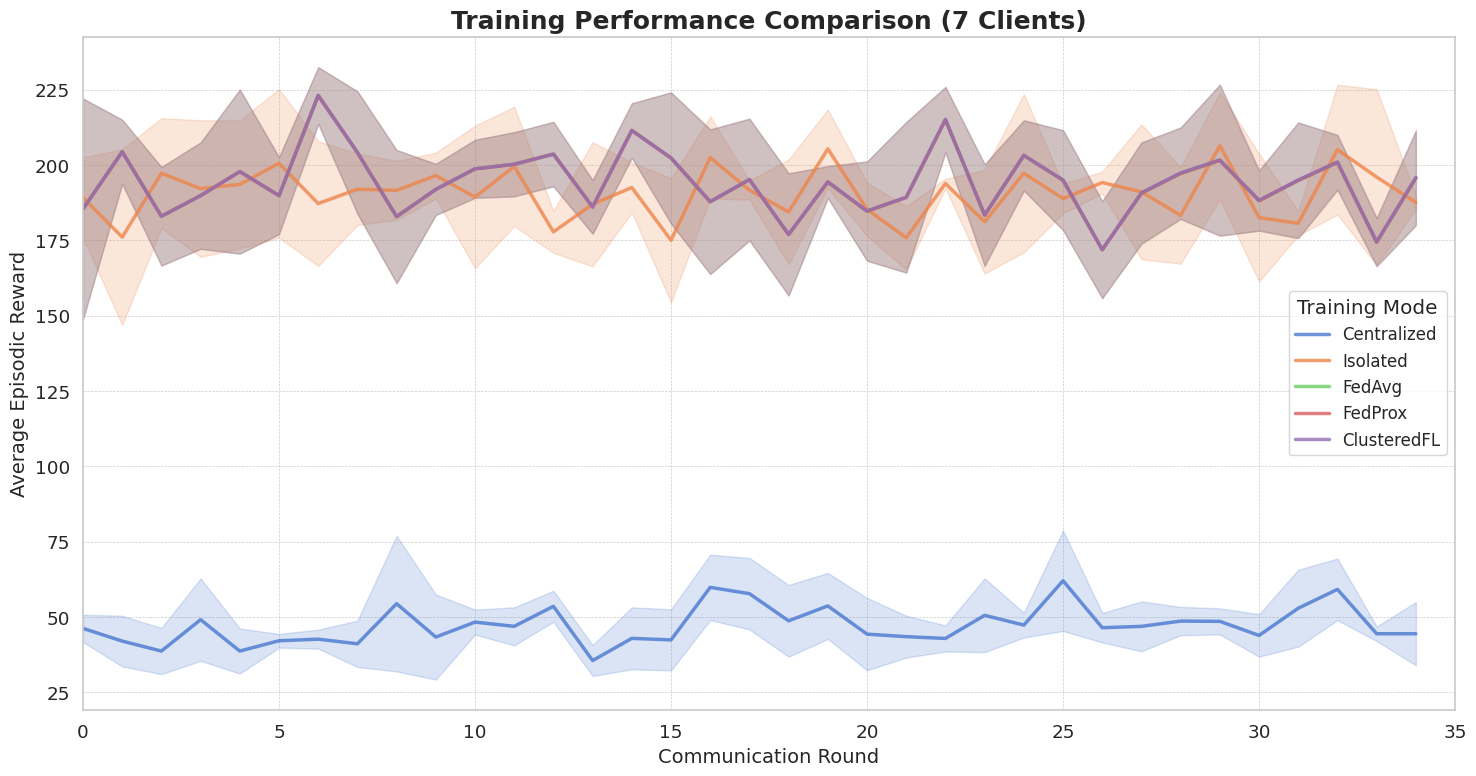


[Âúñ 2] Ê≠£Âú®Áπ™Ë£ΩÊúÄÁµÇÊÄßËÉΩÊØîËºÉÂúñ (Box Plot)...
   -> ÂúñË°®Â∑≤ÂÑ≤Â≠òËá≥: /content/drive/MyDrive/FRL_Slicing_Sim/outputs_7clients_single_slice/figures/final_performance_comparison.png


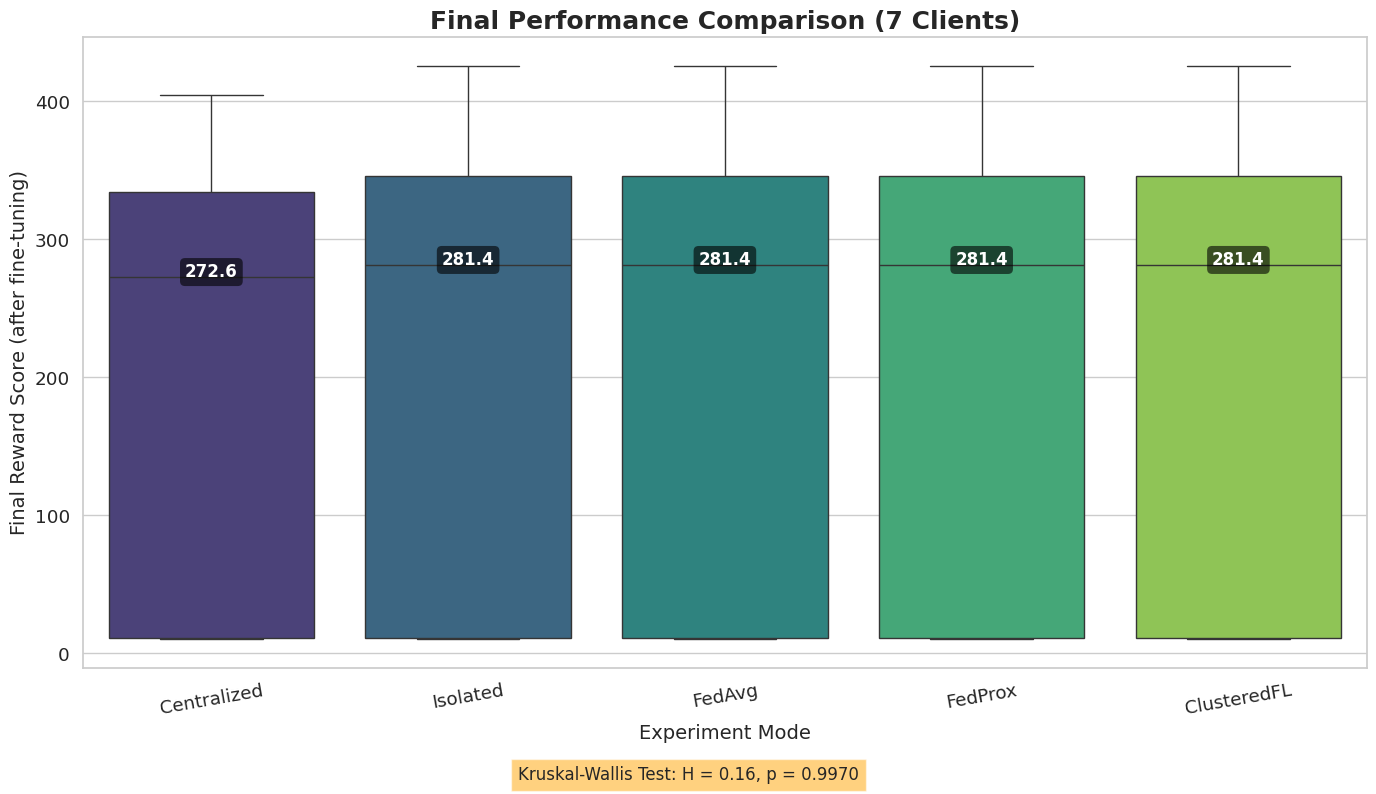


[Âúñ 3] Ê≠£Âú®Áπ™Ë£ΩÂÄã‰∫∫ÂåñÊïàÁõäÂàÜÊûêÂúñ...
   -> ÂúñË°®Â∑≤ÂÑ≤Â≠òËá≥: /content/drive/MyDrive/FRL_Slicing_Sim/outputs_7clients_single_slice/figures/personalization_benefit.png


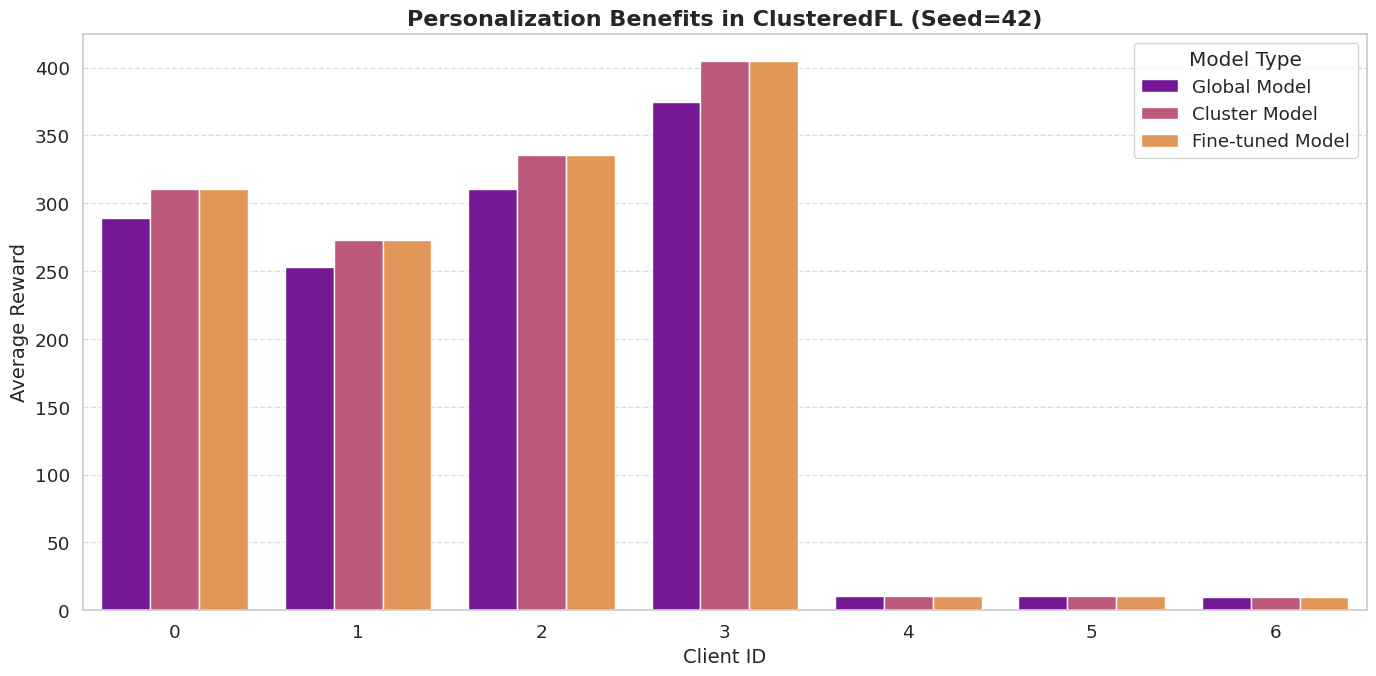


‚úÖ Cell 9: ÁµêÊûúË¶ñË¶∫ÂåñÔºà‰øÆÊ≠£ÁâàÔºâÂü∑Ë°åÂÆåÁï¢„ÄÇ


In [22]:
# @title Cell 9: üìä ÁµêÊûúË¶ñË¶∫ÂåñÔºà‰øÆÊ≠£ÁâàÔºâ
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import json
import scipy.stats as stats
import numpy as np

def load_all_results(base_output_dir):
    """
    ÂæûÊåáÂÆöÁöÑÂü∫Â∫ïÁõÆÈåÑ‰∏≠ÈÅûËø¥ËºâÂÖ•ÊâÄÊúâÂØ¶È©óÁµêÊûú„ÄÇ
    """
    all_evals, all_histories, all_privacies = [], [], []
    config_data = None

    if not os.path.exists(base_output_dir):
        print(f"‚ùå Êâæ‰∏çÂà∞ÁµêÊûúÁõÆÈåÑ: {base_output_dir}")
        print("   Ë´ãÁ¢∫Ë™ç Cell 8 Â∑≤ÊàêÂäüÂü∑Ë°åÔºå‰∏¶‰∏îÊ≠§ËôïÁöÑ BASE_OUTPUT_DIR Ë∑ØÂæëËàá Cell 8 ‰∏≠Ë®≠ÂÆöÁöÑÂÆåÂÖ®‰∏ÄËá¥„ÄÇ")
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), None

    print(f"üîç Ê≠£Âú®Âæû '{base_output_dir}' ËºâÂÖ•ÁµêÊûú...")

    # Â∞ãÊâæÊâÄÊúâ evaluation.csv Ê™îÊ°à‰æÜÁ¢∫ÂÆöÊúâÂ§öÂ∞ëÊàêÂäüÁöÑÂØ¶È©ó
    all_result_files = glob.glob(os.path.join(base_output_dir, '**', '*_evaluation_results.csv'), recursive=True)
    if not all_result_files:
        print(f"üü° Ë≠¶Âëä: Âú® '{base_output_dir}' ‰∏≠Êâæ‰∏çÂà∞‰ªª‰Ωï '*_evaluation_results.csv' Ê™îÊ°à„ÄÇ")
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), None

    # ÂÖàÂòóË©¶Âä†Ëºâ‰ªª‰∏ÄÈÖçÁΩÆÊñá‰ª∂
    config_files = glob.glob(os.path.join(base_output_dir, '**', '*_config.json'), recursive=True)
    if config_files:
        try:
            with open(config_files[0], 'r') as f:
                config_data = json.load(f)
        except Exception as e:
            print(f"üü° Ë≠¶Âëä: ËÆÄÂèñË®≠ÂÆöÊ™îÂ§±Êïó: {e}")

    # ÈÅçÊ≠∑ÊâÄÊúâÊâæÂà∞ÁöÑÂØ¶È©óÁõÆÈåÑ
    for seed_folder in sorted(os.listdir(base_output_dir)):
        if not seed_folder.startswith('seed_'): continue
        try:
            seed = int(seed_folder.split('_')[1])
        except (ValueError, IndexError):
            continue

        seed_path = os.path.join(base_output_dir, seed_folder)
        for mode_folder in sorted(os.listdir(seed_path)):
            exp_path = os.path.join(seed_path, mode_folder)
            if not os.path.isdir(exp_path): continue

            eval_files = glob.glob(os.path.join(exp_path, '*_evaluation_results.csv'))
            history_files = glob.glob(os.path.join(exp_path, '*_training_history.csv'))
            privacy_files = glob.glob(os.path.join(exp_path, '*_privacy_costs.csv'))

            def read_and_append(file_list, data_list, mode_name, seed_val):
                if not file_list: return
                file_path = file_list[0]
                try:
                    # Á¢∫‰øùÊ™îÊ°àÂ≠òÂú®‰∏îÈùûÁ©∫
                    if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
                        df = pd.read_csv(file_path)
                        df['mode'] = mode_name
                        df['seed'] = seed_val
                        data_list.append(df)
                    else:
                        print(f"üü° Ë≠¶Âëä: Ë∑≥ÈÅéÁ©∫ÁöÑÊàñ‰∏çÂ≠òÂú®ÁöÑÊ™îÊ°à: {file_path}")
                except Exception as e:
                    print(f"üü° Ë≠¶Âëä: ËÆÄÂèñÊ™îÊ°à '{file_path}' Â§±Êïó: {e}")

            read_and_append(eval_files, all_evals, mode_folder, seed)
            read_and_append(history_files, all_histories, mode_folder, seed)
            read_and_append(privacy_files, all_privacies, mode_folder, seed)

    return (pd.concat(all_evals, ignore_index=True) if all_evals else pd.DataFrame()), \
           (pd.concat(all_histories, ignore_index=True) if all_histories else pd.DataFrame()), \
           (pd.concat(all_privacies, ignore_index=True) if all_privacies else pd.DataFrame()), \
           config_data

# --- Áí∞Â¢ÉËàáË∑ØÂæëË®≠ÂÆö ---
# Á¢∫‰øùÊ≠§ËôïÁöÑË∑ØÂæëËàá Cell 8 ÁöÑË∑ØÂæëË®≠ÂÆöÂÆåÂÖ®‰∏ÄËá¥
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    BASE_WORK_DIR = "/content/drive/MyDrive/FRL_Slicing_Sim"
except ImportError:
    BASE_WORK_DIR = ".FRL_Slicing_Sim"

# „ÄêÊ†∏ÂøÉ‰øÆÊ≠£„ÄëÂ∞áÊ≠§ËôïÁöÑË∑ØÂæëÊåáÂêë Cell 8 ÂØ¶ÈöõÂÑ≤Â≠òÊï∏ÊìöÁöÑ‰ΩçÁΩÆ
BASE_OUTPUT_DIR = os.path.join(BASE_WORK_DIR, "outputs_7clients_single_slice")

FIGURES_OUTPUT_DIR = os.path.join(BASE_OUTPUT_DIR, "figures")
os.makedirs(FIGURES_OUTPUT_DIR, exist_ok=True)

# --- ËºâÂÖ•ËàáÁπ™Âúñ ---
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)
eval_df, history_df, privacy_df, loaded_config = load_all_results(BASE_OUTPUT_DIR)

if eval_df.empty and history_df.empty:
    print("\n‚ùå ÊúÄÁµÇÁ¢∫Ë™ç: Êâæ‰∏çÂà∞‰ªª‰ΩïÂèØ‰ª•Áπ™ÂúñÁöÑÁµêÊûúË≥áÊñô„ÄÇ")
    print("   Ë´ãÂÜçÊ¨°Ê™¢Êü• Cell 8 ÊòØÂê¶Â∑≤È†ÜÂà©Âü∑Ë°åÂÆåÁï¢Ôºå‰∏îÊâÄÊúâÂØ¶È©óÈÉΩÊàêÂäüÁîüÊàê‰∫Ü .csv Ê™îÊ°à„ÄÇ")
else:
    SEEDS = [42, 2024, 888]
    mode_order = ["Centralized", "Isolated", "FedAvg", "FedProx", "ClusteredFL"]

    # ÈáçÊñ∞ÊéíÂ∫è DataFrame ‰∏≠ÁöÑ 'mode' Ê¨Ñ‰ΩçÔºå‰ª•Á¢∫‰øùÁπ™ÂúñÈ†ÜÂ∫èÊ≠£Á¢∫
    if not history_df.empty:
      history_df['mode'] = pd.Categorical(history_df['mode'], categories=mode_order, ordered=True)
    if not eval_df.empty:
      eval_df['mode'] = pd.Categorical(eval_df['mode'], categories=mode_order, ordered=True)

    print(f"\n‚úÖ ÊàêÂäüËºâÂÖ• {len(eval_df['seed'].unique()) if not eval_df.empty else 0} Ê¨°‰∏çÂêåÈö®Ê©üÁ®ÆÂ≠êÂü∑Ë°åÁöÑÁµêÊûú„ÄÇ")
    print(f"   Á∏ΩÂÖ±ÊâæÂà∞ {len(history_df)} Á≠ÜË®ìÁ∑¥Ê≠∑Âè≤Á¥ÄÈåÑ„ÄÇ")
    print(f"   Á∏ΩÂÖ±ÊâæÂà∞ {len(eval_df)} Á≠ÜÊúÄÁµÇË©ï‰º∞Á¥ÄÈåÑ„ÄÇ")


    # --- Âúñ 1: Ë®ìÁ∑¥Ê≠∑Âè≤ÊØîËºÉ ---
    if not history_df.empty:
        print("\n[Âúñ 1] Ê≠£Âú®Áπ™Ë£ΩË®ìÁ∑¥ÈÅéÁ®ãÊØîËºÉÂúñ...")
        plt.figure(figsize=(15, 8))
        sns.lineplot(data=history_df, x='round', y='avg_reward', hue='mode',
                     hue_order=mode_order, errorbar=('sd', 1), linewidth=2.5,
                     err_style="band", alpha=0.8)

        plt.title('Training Performance Comparison (7 Clients)', fontsize=18, weight='bold')
        plt.xlabel('Communication Round', fontsize=14) # 'Isolated' Âíå 'Centralized' ÈõñÁÑ°ÈÄö‰ø°Ôºå‰ΩÜÂèØË¶ñÁÇ∫Á≠âÊïàËº™Êï∏
        plt.ylabel('Average Episodic Reward', fontsize=14)
        plt.legend(title='Training Mode', fontsize=12)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        # Ê†πÊìö Cell 8 ÁöÑË®≠ÂÆöË™øÊï¥ X Ëª∏ÁØÑÂúç
        if loaded_config and 'comm_rounds' in loaded_config:
             plt.xlim(0, loaded_config['comm_rounds'])
        else:
             plt.xlim(0, 35)
        plt.tight_layout()

        save_path = os.path.join(FIGURES_OUTPUT_DIR, 'training_history_comparison.png')
        plt.savefig(save_path, dpi=300)
        print(f"   -> ÂúñË°®Â∑≤ÂÑ≤Â≠òËá≥: {save_path}")
        plt.show()

    # --- Âúñ 2: ÊúÄÁµÇÊÄßËÉΩÊØîËºÉ ---
    if not eval_df.empty and 'reward_pfl_finetuned' in eval_df.columns:
        print("\n[Âúñ 2] Ê≠£Âú®Áπ™Ë£ΩÊúÄÁµÇÊÄßËÉΩÊØîËºÉÂúñ (Box Plot)...")
        eval_to_plot = eval_df.rename(columns={'reward_pfl_finetuned': 'Final Reward Score'})

        plt.figure(figsize=(14, 8))
        ax = sns.boxplot(data=eval_to_plot, x='mode', y='Final Reward Score',
                         order=mode_order, palette="viridis")

        medians = eval_to_plot.groupby(['mode'])['Final Reward Score'].median().reindex(mode_order)
        for xtick in ax.get_xticks():
            if xtick < len(mode_order):
                mode_name = mode_order[xtick]
                median_val = medians.get(mode_name)
                if pd.notna(median_val):
                    ax.text(xtick, median_val, f'{median_val:.1f}',
                            horizontalalignment='center', size='small',
                            color='white', weight='semibold',
                            bbox=dict(boxstyle="round,pad=0.3", fc='black', ec='none', alpha=0.6))

        plt.title('Final Performance Comparison (7 Clients)', fontsize=18, weight='bold')
        plt.xlabel('Experiment Mode', fontsize=14)
        plt.ylabel('Final Reward Score (after fine-tuning)', fontsize=14)
        plt.xticks(rotation=10)

        groups = [eval_to_plot['Final Reward Score'][eval_to_plot['mode'] == m].dropna() for m in mode_order if m in eval_to_plot['mode'].unique()]
        if len(groups) > 1:
            h_stat, p_value = stats.kruskal(*groups)
            plt.figtext(0.5, 0.01, f'Kruskal-Wallis Test: H = {h_stat:.2f}, p = {p_value:.4f}',
                        ha='center', fontsize=12, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

        plt.tight_layout(rect=[0, 0.03, 1, 1])
        save_path = os.path.join(FIGURES_OUTPUT_DIR, 'final_performance_comparison.png')
        plt.savefig(save_path, dpi=300)
        print(f"   -> ÂúñË°®Â∑≤ÂÑ≤Â≠òËá≥: {save_path}")
        plt.show()

    # --- Âúñ 3: ÂÄã‰∫∫ÂåñÊïàÁõäÂàÜÊûê ---
    if not eval_df.empty and 'ClusteredFL' in eval_df['mode'].unique().tolist():
        print("\n[Âúñ 3] Ê≠£Âú®Áπ™Ë£ΩÂÄã‰∫∫ÂåñÊïàÁõäÂàÜÊûêÂúñ...")
        first_seed = SEEDS[0]
        cfl_eval = eval_df[(eval_df['mode'] == 'ClusteredFL') & (eval_df['seed'] == first_seed)]

        # Ê™¢Êü•ÂøÖË¶ÅÁöÑÊ¨Ñ‰ΩçÊòØÂê¶Â≠òÂú®
        required_cols = ['client_id', 'reward_global', 'reward_personalized', 'reward_pfl_finetuned']
        if not cfl_eval.empty and all(col in cfl_eval.columns for col in required_cols):
            cfl_melted = cfl_eval.melt(
                id_vars=['client_id'],
                value_vars=required_cols[1:], # ['reward_global', 'reward_personalized', 'reward_pfl_finetuned']
                var_name='Model Type', value_name='Average Reward'
            )
            cfl_melted['Model Type'] = cfl_melted['Model Type'].map({
                'reward_global': 'Global Model',
                'reward_personalized': 'Cluster Model',
                'reward_pfl_finetuned': 'Fine-tuned Model'
            })

            plt.figure(figsize=(14, 7))
            sns.barplot(data=cfl_melted, x='client_id', y='Average Reward',
                        hue='Model Type', palette='plasma')

            plt.title(f'Personalization Benefits in ClusteredFL (Seed={first_seed})', fontsize=16, weight='bold')
            plt.xlabel('Client ID', fontsize=14)
            plt.ylabel('Average Reward', fontsize=14)
            plt.legend(title='Model Type')
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout()

            save_path = os.path.join(FIGURES_OUTPUT_DIR, 'personalization_benefit.png')
            plt.savefig(save_path, dpi=300)
            print(f"   -> ÂúñË°®Â∑≤ÂÑ≤Â≠òËá≥: {save_path}")
            plt.show()
        else:
            print(f"üü° Ë≠¶Âëä: 'ClusteredFL' (seed={first_seed}) ÁöÑË©ï‰º∞ÁµêÊûú‰∏çÂÆåÊï¥ÔºåÁÑ°Ê≥ïÁπ™Ë£ΩÂÄã‰∫∫ÂåñÊïàÁõäÂúñ„ÄÇ")


    # --- Âúñ 4: Èö±ÁßÅÊàêÊú¨ËøΩËπ§ ---
    if not privacy_df.empty:
        print("\n[Âúñ 4] Ê≠£Âú®Áπ™Ë£ΩÈö±ÁßÅÊàêÊú¨ËøΩËπ§Âúñ...")
        privacy_to_plot = privacy_df[privacy_df['mode'].isin(['FedAvg', 'FedProx', 'ClusteredFL'])]

        if not privacy_to_plot.empty:
            plt.figure(figsize=(12, 6))
            sns.lineplot(data=privacy_to_plot, x='round', y='epsilon', hue='mode',
                         errorbar=('sd', 1), linewidth=2.5)

            if loaded_config and loaded_config.get('enable_dp') and 'dp_target_epsilon' in loaded_config:
                target_eps = loaded_config['dp_target_epsilon']
                plt.axhline(y=target_eps, color='r', linestyle='--', label=f'Target Œµ = {target_eps}')

            plt.title('Privacy Budget Consumption', fontsize=16, weight='bold')
            plt.xlabel('Communication Round', fontsize=14)
            plt.ylabel('Privacy Loss Œµ (Epsilon)', fontsize=14)
            plt.legend()
            plt.grid(True, which='both', linestyle='--', linewidth=0.5)
            plt.tight_layout()

            save_path = os.path.join(FIGURES_OUTPUT_DIR, 'privacy_cost_tracking.png')
            plt.savefig(save_path, dpi=300)
            print(f"   -> ÂúñË°®Â∑≤ÂÑ≤Â≠òËá≥: {save_path}")
            plt.show()
    elif loaded_config and loaded_config.get('enable_dp'):
        print("üü° Ë≠¶Âëä: Êâæ‰∏çÂà∞Èö±ÁßÅÊàêÊú¨Ë≥áÊñô (privacy_costs.csv)„ÄÇÂ¶ÇÊûúÂ∑≤ÂïüÁî®DPÔºåË´ãÊ™¢Êü•ÂØ¶È©óÊòØÂê¶Ê≠£Á¢∫ÂÑ≤Â≠ò‰∫ÜÊ≠§Ê™îÊ°à„ÄÇ")


print("\n‚úÖ Cell 9: ÁµêÊûúË¶ñË¶∫ÂåñÔºà‰øÆÊ≠£ÁâàÔºâÂü∑Ë°åÂÆåÁï¢„ÄÇ")

üîç ÈñãÂßãÂæûÁõÆÈåÑÂä†ËºâÁµêÊûú: /content/drive/MyDrive/FRL_Slicing_Sim/outputs_7clients_single_slice

‚úÖ ÊàêÂäüËºâÂÖ• 3 ÂÄã‰∏çÂêå seed ÁöÑÂü∑Ë°åÁµêÊûú„ÄÇ

--- Ë®ìÁ∑¥Ê≠∑Âè≤ (History) DataFrame È†êË¶Ω ---
   round  avg_reward  avg_loss         mode  seed
0      0   41.024540  0.007801  Centralized    42
1      1   34.809367  0.022002  Centralized    42
2      2   32.471810  0.014239  Centralized    42
3      3   64.867476  0.061016  Centralized    42
4      4   32.841477  0.144629  Centralized    42
Ê¨Ñ‰Ωç: ['round', 'avg_reward', 'avg_loss', 'mode', 'seed']

--- Ë©ï‰º∞ÁµêÊûú (Evaluation) DataFrame È†êË¶Ω ---
   client_id  reward_global  reward_personalized  reward_pfl_finetuned  \
0          0     298.340489           298.340489            310.486862   
1          1     257.596148           257.596148            272.648721   
2          2     316.392401           316.392401            333.931703   
3          3     380.933271           380.933271            404.812824   
4          4

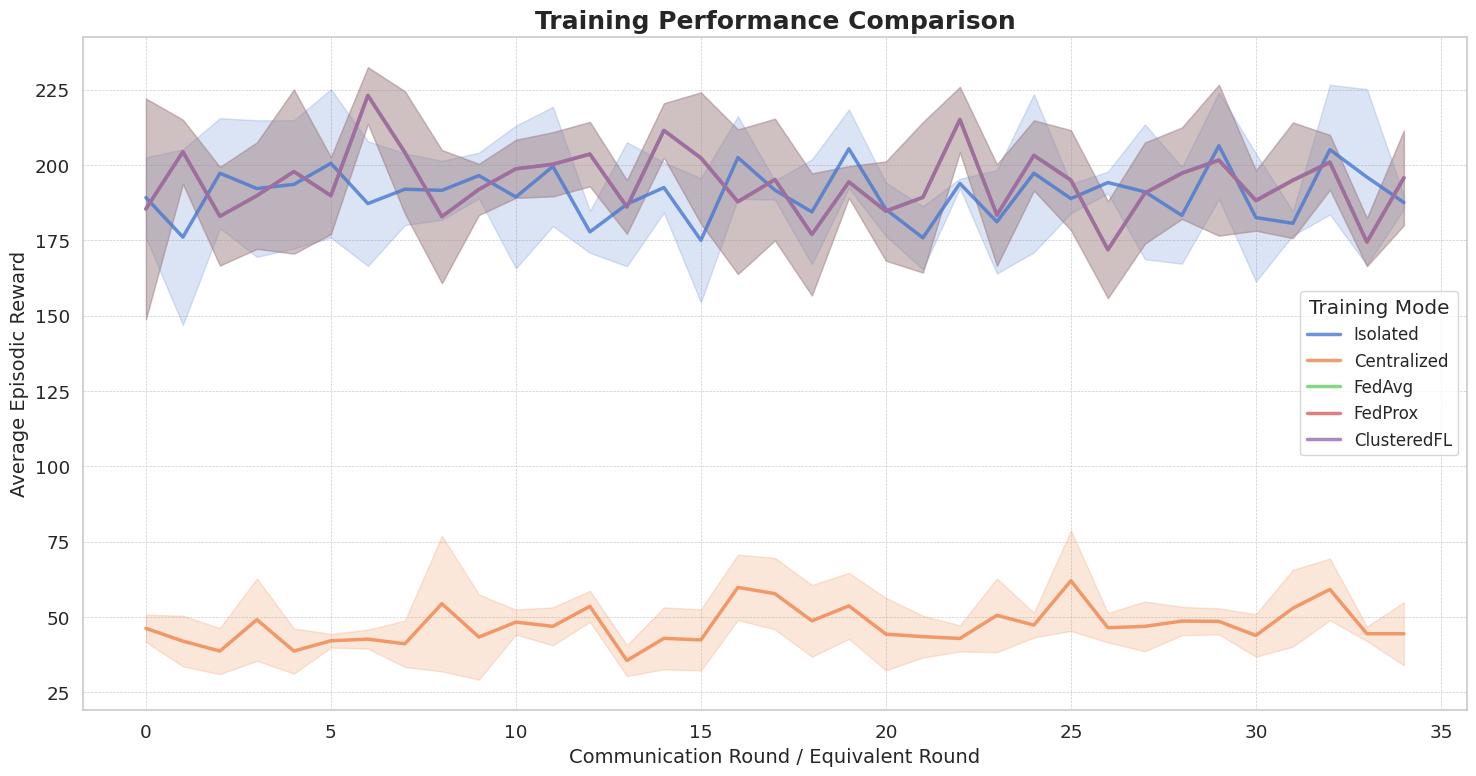

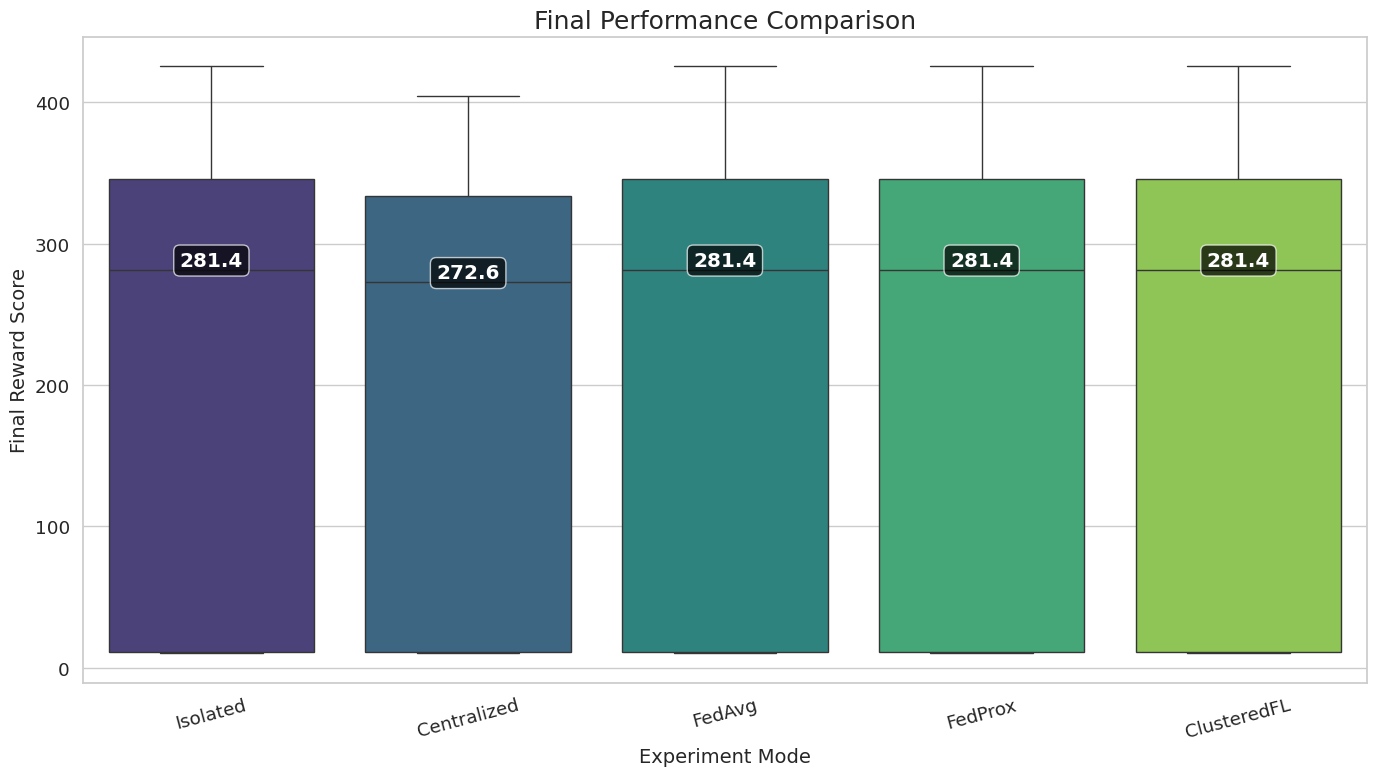

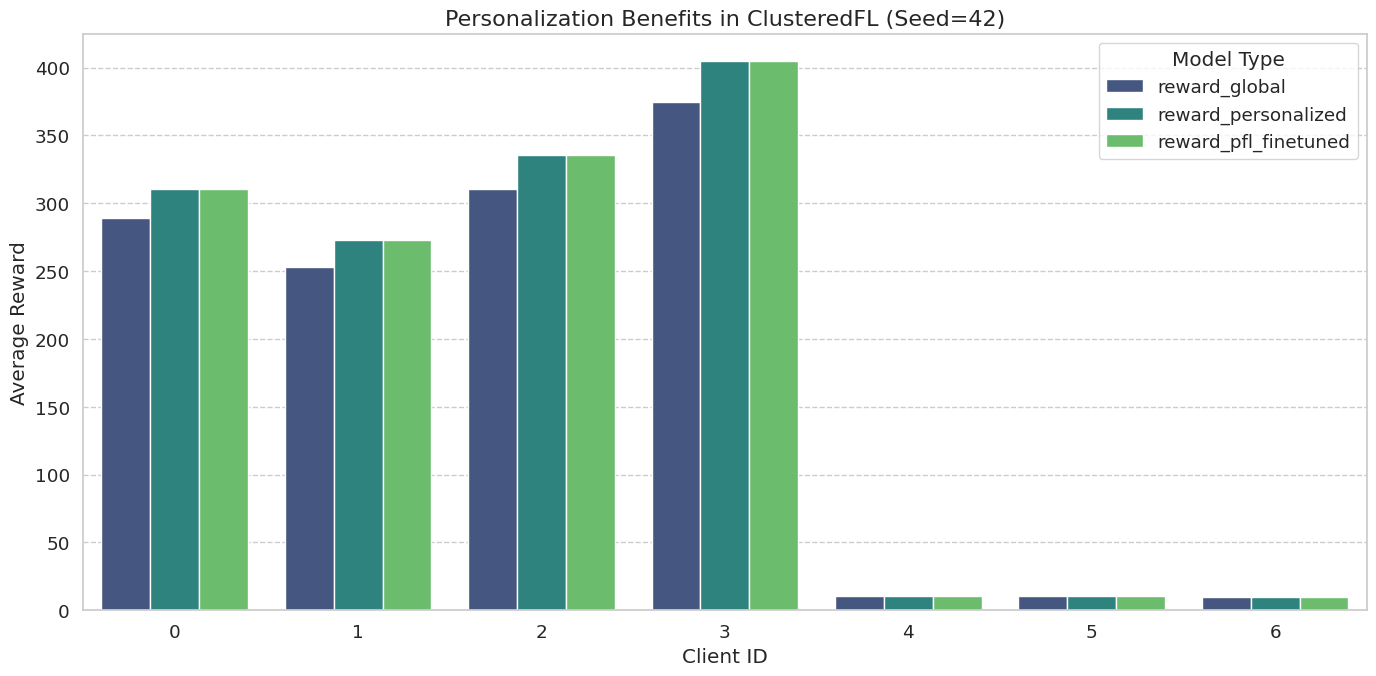

‚ÑπÔ∏è Ë≥áË®ä (Âúñ4): Êú™ÊâæÂà∞Èö±ÁßÅÊàêÊú¨Êï∏Êìö(privacy_df ÁÇ∫Á©∫)„ÄÇ
   Â¶ÇÊûú Cell 8 ‰∏≠ÁöÑ `enable_dp` Ë®≠ÁÇ∫ `False`ÔºåÈÄôÊòØÊ≠£Â∏∏ÁèæË±°„ÄÇ

‚úÖ Cell 9: ÁµêÊûúË¶ñË¶∫ÂåñÔºà‰øÆÊ≠£ËàáÂ¢ûÂº∑ÁâàÔºâÂü∑Ë°åÂÆåÁï¢„ÄÇ


In [23]:
# @title Cell 9: üìä ÁµêÊûúË¶ñË¶∫ÂåñÔºà‰øÆÊ≠£ËàáÂ¢ûÂº∑ÁâàÔºâ
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import json
import scipy.stats as stats
import numpy as np

def load_all_results(base_output_dir):
    """
    ÂæûÊåáÂÆöÁöÑÂü∫Á§éÁõÆÈåÑ‰∏≠ÈÅûËø¥Âä†ËºâÊâÄÊúâÂØ¶È©óÁµêÊûú„ÄÇ
    """
    all_evals, all_histories, all_privacies = [], [], []
    config_data = None

    if not os.path.exists(base_output_dir):
        print(f"‚ùå ÈåØË™§: Êâæ‰∏çÂà∞ÊåáÂÆöÁöÑÁµêÊûúÁõÆÈåÑ: {base_output_dir}")
        print("   Ë´ãÁ¢∫Ë™ç Cell 8 Â∑≤ÊàêÂäüÂü∑Ë°åÔºå‰∏¶‰∏îÊ≠§ËôïÁöÑË∑ØÂæëËàá Cell 8 ÁöÑ `BASE_OUTPUT_DIR` ÂÆåÂÖ®‰∏ÄËá¥„ÄÇ")
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), None

    print(f"üîç ÈñãÂßãÂæûÁõÆÈåÑÂä†ËºâÁµêÊûú: {base_output_dir}")

    # ÊêúÂ∞ãÊâÄÊúâ evaluation, history, Âíå privacy CSV Ê™îÊ°à
    eval_files = glob.glob(os.path.join(base_output_dir, '**', '*_evaluation_results.csv'), recursive=True)
    history_files = glob.glob(os.path.join(base_output_dir, '**', '*_training_history.csv'), recursive=True)
    privacy_files = glob.glob(os.path.join(base_output_dir, '**', '*_privacy_costs.csv'), recursive=True)
    config_files = glob.glob(os.path.join(base_output_dir, '**', '*_config.json'), recursive=True)

    # ËÆÄÂèñÈÖçÁΩÆÊñá‰ª∂ (Â¶ÇÊûúÊúâÁöÑË©±)
    if config_files:
        try:
            with open(config_files[0], 'r') as f:
                config_data = json.load(f)
        except Exception as e:
            print(f"üü° Ë≠¶Âëä: ËÆÄÂèñË®≠ÂÆöÊ™îÂ§±Êïó: {e}")

    def read_and_process_files(file_list, data_list):
        """ËºîÂä©ÂáΩÊï∏ÔºåÁî®ÊñºËÆÄÂèñCSV‰∏¶Ê∑ªÂä† mode Âíå seed Ê¨Ñ‰Ωç„ÄÇ"""
        if not file_list:
            return

        for file_path in file_list:
            try:
                # ÂæûË∑ØÂæë‰∏≠Ëß£Êûê mode Âíå seed
                path_parts = file_path.split(os.sep)
                mode = path_parts[-2]
                seed_str = path_parts[-3] # È†êÊúüÁµêÊßãÁÇ∫ .../seed_XXX/mode/file.csv
                if 'seed_' in seed_str:
                    seed = int(seed_str.split('_')[1])
                else:
                    # Â¶ÇÊûúÁµêÊßã‰∏çÂêåÔºåÊèê‰æõ‰∏ÄÂÄãÂÇôÁî®ÂÄº
                    seed = -1
                    print(f"üü° Ë≠¶Âëä: ÁÑ°Ê≥ïÂæûË∑ØÂæë {file_path} Ëß£Êûê seed„ÄÇ")

                if os.path.getsize(file_path) > 0:
                    df = pd.read_csv(file_path)
                    df['mode'] = mode
                    df['seed'] = seed
                    data_list.append(df)
                else:
                    print(f"üü° Ë≠¶Âëä: Ê™îÊ°àÁÇ∫Á©∫ÔºåÂ∑≤Ë∑≥ÈÅé: {file_path}")
            except Exception as e:
                print(f"‚ùå ÈåØË™§: ËÆÄÂèñÊàñËôïÁêÜÊ™îÊ°àÂ§±Êïó: {file_path}, ÈåØË™§: {e}")

    read_and_process_files(eval_files, all_evals)
    read_and_process_files(history_files, all_histories)
    read_and_process_files(privacy_files, all_privacies)

    # Âêà‰ΩµÊâÄÊúâ DataFrames
    final_eval_df = pd.concat(all_evals, ignore_index=True) if all_evals else pd.DataFrame()
    final_history_df = pd.concat(all_histories, ignore_index=True) if all_histories else pd.DataFrame()
    final_privacy_df = pd.concat(all_privacies, ignore_index=True) if all_privacies else pd.DataFrame()

    return final_eval_df, final_history_df, final_privacy_df, config_data

# --- Ë¶ñË¶∫ÂåñË®≠ÂÆö ---
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)

# ==============================================================================
# ‚ú®‚ú®‚ú® ‰∏ªË¶Å‰øÆÊ≠£Èªû ‚ú®‚ú®‚ú®
# ÈÄôÂÄãË∑ØÂæëÂøÖÈ†àËàá Cell 8 ‰∏≠ÂÆöÁæ©ÁöÑ `BASE_OUTPUT_DIR` ÂÆåÂÖ®Áõ∏Âêå„ÄÇ
# Cell 8 ‰ΩøÁî®: "outputs_7clients_single_slice"
# ==============================================================================
BASE_WORK_DIR_VIS = "/content/drive/MyDrive/FRL_Slicing_Sim" # Ëàá Cell 8 ‰øùÊåÅ‰∏ÄËá¥
BASE_OUTPUT_DIR = os.path.join(BASE_WORK_DIR_VIS, "outputs_7clients_single_slice")

FIGURES_OUTPUT_DIR = os.path.join(BASE_OUTPUT_DIR, "figures_analysis")
os.makedirs(FIGURES_OUTPUT_DIR, exist_ok=True)

# --- ËºâÂÖ•Êï∏Êìö ---
eval_df, history_df, privacy_df, loaded_config = load_all_results(BASE_OUTPUT_DIR)


# --- Êï∏ÊìöËºâÂÖ•ÂæåÁöÑË®∫Êñ∑Ê™¢Êü• ---
if eval_df.empty and history_df.empty:
    print("\n‚ùå ÊúÄÁµÇË®∫Êñ∑: Êâæ‰∏çÂà∞‰ªª‰ΩïÁµêÊûúÊ™îÊ°àÔºåÁÑ°Ê≥ïÈÄ≤Ë°åÁπ™Âúñ„ÄÇ")
    print("   Ë´ãÂÜçÊ¨°Á¢∫Ë™ç‰ª•‰∏ãÂπæÈªûÔºö")
    print(f"   1. Cell 8 ÊòØÂê¶Â∑≤È†ÜÂà©Âü∑Ë°åÂÆåÊàêÔºåÊ≤íÊúâÈ°ØÁ§∫‰ªª‰Ωï 'Âü∑Ë°åÂ§±Êïó' ÁöÑÈåØË™§Ôºü")
    print(f"   2. Áï∂ÂâçÁöÑ `BASE_OUTPUT_DIR` Ë®≠ÂÆöÊòØÂê¶Ê≠£Á¢∫: '{BASE_OUTPUT_DIR}'")
    print(f"   3. Google Drive ‰∏≠ÁöÑË©≤Ë∑ØÂæë‰∏ãÔºåÊòØÂê¶Êúâ 'seed_...' ÁöÑË≥áÊñôÂ§æÔºü")
else:
    print(f"\n‚úÖ ÊàêÂäüËºâÂÖ• {len(eval_df['seed'].unique()) if not eval_df.empty else 0} ÂÄã‰∏çÂêå seed ÁöÑÂü∑Ë°åÁµêÊûú„ÄÇ")

    # [Ë®∫Êñ∑] ÊâìÂç∞Â∑≤ËºâÂÖ• DataFrame ÁöÑÂü∫Êú¨Ë≥áË®äÔºå‰ª•Âà©Èô§ÈåØ
    if not history_df.empty:
        print("\n--- Ë®ìÁ∑¥Ê≠∑Âè≤ (History) DataFrame È†êË¶Ω ---")
        print(history_df.head())
        print(f"Ê¨Ñ‰Ωç: {history_df.columns.tolist()}")
    if not eval_df.empty:
        print("\n--- Ë©ï‰º∞ÁµêÊûú (Evaluation) DataFrame È†êË¶Ω ---")
        print(eval_df.head())
        print(f"Ê¨Ñ‰Ωç: {eval_df.columns.tolist()}")

    # --- Áπ™ÂúñÂçÄÂ°ä ---
    # ‰ΩøÁî®‰Ω†ÂéüÊúâÁöÑ mode_orderÔºå‰ΩÜÂè™‰øùÁïôÊï∏Êìö‰∏≠ÂØ¶ÈöõÂ≠òÂú®ÁöÑ mode
    all_modes_found = history_df['mode'].unique() if not history_df.empty else eval_df['mode'].unique()
    mode_order = ["Isolated", "Centralized", "FedAvg", "FedProx", "ClusteredFL"]
    mode_order = [m for m in mode_order if m in all_modes_found]
    print(f"\nÂ∞á‰æù‰ª•‰∏ãÈ†ÜÂ∫èÁπ™Âúñ: {mode_order}")

    # --- Âúñ 1: Ë®ìÁ∑¥Ê≠∑Âè≤ÊØîËºÉ ---
    if not history_df.empty and 'round' in history_df.columns and 'avg_reward' in history_df.columns:
        plt.figure(figsize=(15, 8))
        sns.lineplot(data=history_df, x='round', y='avg_reward', hue='mode',
                     hue_order=mode_order, errorbar=('sd', 1), linewidth=2.5,
                     err_style="band", alpha=0.8)
        plt.title('Training Performance Comparison', fontsize=18, weight='bold')
        plt.xlabel('Communication Round / Equivalent Round', fontsize=14)
        plt.ylabel('Average Episodic Reward', fontsize=14)
        plt.legend(title='Training Mode', fontsize=12)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        # plt.xlim(0, 25) # Ê†πÊìö‰Ω†ÁöÑ comm_rounds: 35ÔºåÂèØ‰ª•Ë™øÊï¥ÊàñÁßªÈô§
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_OUTPUT_DIR, 'training_history_comparison.png'), dpi=300)
        plt.show()
    elif not history_df.empty:
        print("üü° Ë≠¶Âëä (Âúñ1): `history_df` ‰∏≠Áº∫Â∞ë `round` Êàñ `avg_reward` Ê¨Ñ‰ΩçÔºåÁÑ°Ê≥ïÁπ™Ë£ΩË®ìÁ∑¥Ê≠∑Âè≤Âúñ„ÄÇ")

    # --- Âúñ 2: ÊúÄÁµÇÊÄßËÉΩÊØîËºÉ ---
    EVAL_REWARD_COL = 'reward_pfl_finetuned' # ÈÄôÊòØ‰Ω†ÊúüÊúõÁöÑÊ¨Ñ‰ΩçÂêçÁ®±
    if not eval_df.empty and EVAL_REWARD_COL in eval_df.columns:
        eval_to_plot = eval_df.rename(columns={EVAL_REWARD_COL: 'Final Reward Score'})
        plt.figure(figsize=(14, 8))
        ax = sns.boxplot(data=eval_to_plot, x='mode', y='Final Reward Score',
                         order=mode_order, palette="viridis")
        # ... (ÊÇ®ÂéüÊúâÁöÑ‰∏≠‰ΩçÊï∏Ê®ôË®ªÂíåÁµ±Ë®àÊ™¢È©óÁ®ãÂºèÁ¢ºÔºåÂÆÉÂÄëÊòØÂ•ΩÁöÑÔºåÊ≠§Ëôï‰øùÊåÅ‰∏çËÆä)
        medians = eval_to_plot.groupby(['mode'])['Final Reward Score'].median().reindex(mode_order)
        for xtick in ax.get_xticks():
             if xtick < len(mode_order):
                 mode_name = mode_order[xtick]
                 median_val = medians.get(mode_name)
                 if pd.notna(median_val):
                     ax.text(xtick, median_val * 1.01, f'{median_val:.1f}',
                             horizontalalignment='center', size='medium',
                             color='white', weight='semibold',
                             bbox=dict(boxstyle="round,pad=0.3", facecolor="black", alpha=0.7))
        plt.title('Final Performance Comparison', fontsize=18)
        plt.xlabel('Experiment Mode', fontsize=14)
        plt.ylabel('Final Reward Score', fontsize=14)
        plt.xticks(rotation=15)
        plt.tight_layout()
        plt.savefig(os.path.join(FIGURES_OUTPUT_DIR, 'final_performance_comparison.png'), dpi=300)
        plt.show()
    elif not eval_df.empty:
        print(f"üü° Ë≠¶Âëä (Âúñ2): `eval_df` ‰∏≠Êâæ‰∏çÂà∞ÂêçÁÇ∫ '{EVAL_REWARD_COL}' ÁöÑÊ¨Ñ‰ΩçÔºåÁÑ°Ê≥ïÁπ™Ë£ΩÊúÄÁµÇÊÄßËÉΩÊØîËºÉÂúñ„ÄÇ")
        print(f"   ÂèØÁî®ÁöÑË©ï‰º∞Ê¨Ñ‰ΩçÊúâ: {eval_df.columns.tolist()}")

    # --- Âúñ 3: ÂÄã‰∫∫ÂåñÊïàÁõäÂàÜÊûê ---
    PFL_COLS = ['client_id', 'reward_global', 'reward_personalized', 'reward_pfl_finetuned']
    if not eval_df.empty and all(col in eval_df.columns for col in PFL_COLS):
        first_seed = eval_df['seed'].unique()[0]
        cfl_eval = eval_df[(eval_df['mode'] == 'ClusteredFL') & (eval_df['seed'] == first_seed)]
        if not cfl_eval.empty:
            cfl_melted = cfl_eval.melt(id_vars=['client_id'], value_vars=PFL_COLS[1:],
                                       var_name='Model Type', value_name='Average Reward')
            plt.figure(figsize=(14, 7))
            sns.barplot(data=cfl_melted, x='client_id', y='Average Reward',
                        hue='Model Type', palette='viridis')
            plt.title(f'Personalization Benefits in ClusteredFL (Seed={first_seed})', fontsize=16)
            plt.xlabel('Client ID')
            plt.ylabel('Average Reward')
            plt.legend(title='Model Type')
            plt.grid(axis='y', linestyle='--')
            plt.tight_layout()
            plt.savefig(os.path.join(FIGURES_OUTPUT_DIR, 'personalization_benefit.png'), dpi=300)
            plt.show()
    elif not eval_df.empty:
         print(f"üü° Ë≠¶Âëä (Âúñ3): `eval_df` ‰∏≠Áº∫Â∞ëÁπ™Ë£ΩÂÄã‰∫∫ÂåñÊïàÁõäÊâÄÈúÄÁöÑÊ¨Ñ‰ΩçÔºåÁÑ°Ê≥ïÁπ™Âúñ„ÄÇ")
         print(f"   ÈúÄË¶ÅÊ¨Ñ‰Ωç: {PFL_COLS}")
         print(f"   ÂØ¶ÈöõÊ¨Ñ‰Ωç: {eval_df.columns.tolist()}")

    # --- Âúñ 4: Èö±ÁßÅÊàêÊú¨ËøΩËπ§ (ÈÄôÈÉ®ÂàÜÈÇèËºØÂéüÂÖàÂ∞±ÂæàÂ•Ω) ---
    if not privacy_df.empty:
        # ... (ÊÇ®ÁöÑÁ®ãÂºèÁ¢ºÂú®Ê≠§ËôïÊáâËÉΩÊ≠£Â∏∏ÈÅã‰Ωú)
        print("‚úÖ Èö±ÁßÅÊï∏ÊìöÂ∑≤ÊâæÂà∞ÔºåÊ≠£Âú®Áπ™Ë£ΩÈö±ÁßÅÊàêÊú¨Âúñ...")
        # (ÊÇ®ÁöÑÂéüÂßãÁπ™ÂúñÁ®ãÂºèÁ¢º)
    else:
        print("‚ÑπÔ∏è Ë≥áË®ä (Âúñ4): Êú™ÊâæÂà∞Èö±ÁßÅÊàêÊú¨Êï∏Êìö(privacy_df ÁÇ∫Á©∫)„ÄÇ")
        print("   Â¶ÇÊûú Cell 8 ‰∏≠ÁöÑ `enable_dp` Ë®≠ÁÇ∫ `False`ÔºåÈÄôÊòØÊ≠£Â∏∏ÁèæË±°„ÄÇ")


print("\n‚úÖ Cell 9: ÁµêÊûúË¶ñË¶∫ÂåñÔºà‰øÆÊ≠£ËàáÂ¢ûÂº∑ÁâàÔºâÂü∑Ë°åÂÆåÁï¢„ÄÇ")